# Regresión lineal con Bambi

> A good tool improves the way you work. A great tool improves the way you think. -Jeff Duntemann 

In [1]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import bambi as bmb

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
#| code-fold: true

plt.style.use('arviz-doc')

En el Capítulo anterior describimos los ingredientes básicos de los modelos de regresión lineal y cómo generalizarlos para que se ajusten mejor a nuestras necesidades. En este capítulo, seguiremos aprendiendo sobre modelos lineales, pero esta vez trabajaremos con [Bambi](https://bambinos.github.io/bambi/), una interfaz de construcción de modelos bayesianos de alto nivel escrita sobre PyMC. Bambi está diseñado para que sea extremadamente fácil ajustar modelos lineales, incluidos los jerárquicos. Veremos que el dominio de Bambi es en realidad más completo que los simples modelos lineales. En este capítulo vamos a aprender sobre:

* Cómo usar Bambi para construir y ajustar modelos
*  Cómo analizar resultados con Bambi
*  Regresión polinómica y splines
*  Modelos distributivos
*  Predictores categóricos
*  Interacciones
*  Selección de variables con Kulprit

## Una sintaxis para gobernarlos a todos

PyMC tiene una sintaxis muy simple y expresiva, que nos permite construir modelos arbitrarios, esta capacidad puede ser vista como una bendición, pero también como una carga. Bambi, en cambio, se centra en modelos de regresión; esta restricción conduce a una sintaxis más focalizada y características que serían difíciles de implementar en paquetes más generales.

Bambi utiliza una sintaxis de fórmula de Wilkinson similar a la utilizada por muchos paquetes de R como nlme, lme4 o brms. Supongamos que  tenemos un DataFrame como el siguiente:

In [3]:
SIZE = 117
datos = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
datos.head()

,y,x,z,g
0,-0.340618,-0.924333,0.978806,Group A
1,0.182684,0.808523,-0.097891,Group B
2,-0.644645,-1.146860,2.366085,Group C
3,1.363740,0.812695,-0.675292,Group A
4,-0.422170,0.039711,1.556364,Group B


Usando estos datos queremos construir un modelo lineal que prediga `y` a partir de `x`. Usando PyMC haríamos algo como:


```python
with pm.Model() as lm:
    Intercept = pm.Normal("Intercept", 0, 1)
    x = pm.Normal("x", 0, 1)
    y_sigma = pm.HalfNormal("sigma", 1)
    y_mean = Intercept + x * data["x"]
    y = pm.Normal("y", y_mean, y_sigma, observed=data["y"])
```

Usando la sintaxis de Bambi, podemos escribir el mismo modelo como:

In [4]:
un_modelo = bmb.Model("y ~ x", datos)

En el lado izquierdo de `~` tenemos la variable dependiente y en el lado derecho la(s) variable(s) independiente(s). Con esta sintaxis, solo estamos especificando la media ($\mu$ en el modelo `lm` de PyMC). De forma predeterminada, Bambi asume que el likelihood es una Normal. Esto se puede cambiar con el argumento `family`. Esta sintáxis solo especifica cómo se relacionan las variables dependientes e independiente, pero no especifica las distribuciones *a priori*. Bambi internamente define distribuciones a priori debilmente informativas. Al imprimir un modelo de Bambi obtenemos mucha información útil sobre su especificación.

In [5]:
un_modelo

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.0118, sigma: 2.6716)
            x ~ Normal(mu: 0.0, sigma: 2.9293)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0625)

La primera línea muestra la fórmula que usamos para definir el modelo y la segunda línea es el likelihood. En Bambi, usamos el argumento `family` para especificar el . La tercera línea es la función de enlace. Por defecto cada familia tiene asociada una función de enlace, por ej la Gaussiana se asocia a la función identidad. Luego tenemos el número de observaciones utilizadas para ajustar el modelo, y lo siguiente nos dice que estamos modelando linealmente el parámetro $\mu$ de la Gaussiana. Luego, en las siguientes líneas tenemos la estructura del modelo. La primera parte muestra los efectos de nivel común, en este caso, el intercepto y el coefficiente de regressión (la "pendiente") asociado a `x`. En la segunda parte se muestran los parámetros auxiliares, es decir, todos los parámetros no modelados linealmente, en este caso, la desviación estándar.


Si querés omitir el intercepto, tenés dos opciones:

In [6]:
no_intercepto_1 = bmb.Model("y ~ 0 + x", datos)
no_intercepto_1

       Formula: y ~ 0 + x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            x ~ Normal(mu: 0.0, sigma: 2.9293)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0625)

In [7]:
no_intercepto_2 = bmb.Model("y ~ -1 + x", datos)
no_intercepto_2


       Formula: y ~ -1 + x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            x ~ Normal(mu: 0.0, sigma: 2.9293)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 1.0625)

Con Bambi también podemos incluir efectos a nivel de grupo (es decir jerarquías), por ejemplo, si queremos usar la variable `g` para agrupar parcialmente las estimaciones de `x` podemos hacerlo así:

In [8]:
modelo_h = bmb.Model("y ~ x + z + (x | g)", datos)


Para obtener una representación gráfica de la estructura de un modelo de Bambi podemos usar el método `.graph()`, esto requiere que previamente hayamos usado el método `.build()` para construir el modelo. O el método `.fit()` para ajustar el modelo (calcular la distribución posterior de los parámetros). Veamos como lucen `un_modelo` y `modelo_h`:

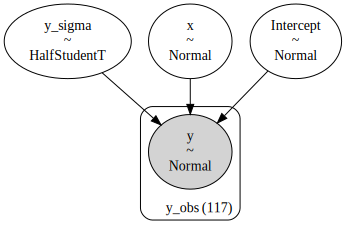

In [9]:
un_modelo.build()
un_modelo.graph()

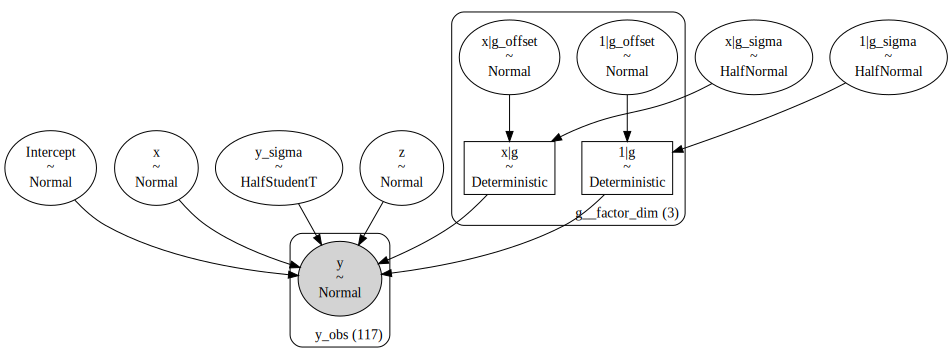

In [10]:
modelo_h.build()
modelo_h.graph()

La sintaxis de la fórmula es muy simple, pero también muy poderosa. Acabamos de arañar la superficie de lo que podemos hacer con él. En lugar de describir la sintaxis de una vez, la mostraremos mediante ejemplos. Así que comencemos ajustando el modelo de bicicleta del capítulo anterior.

## Bicicletas bambinas

In [11]:
bicis = pd.read_csv("datos/bicis.csv")

In [12]:
modelo_t = bmb.Model("alquiladas ~ temperatura", bicis, family="negativebinomial")
idata_t = modelo_t.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alquiladas_alpha, Intercept, temperatura]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


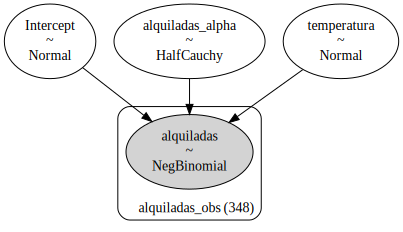

In [13]:
modelo_t.graph()

Ahora vamos a graficar el ajuste medio a posteriori y las predicciones. Para ello usaremos la función `plot_predictions` del módulo `interpret`.


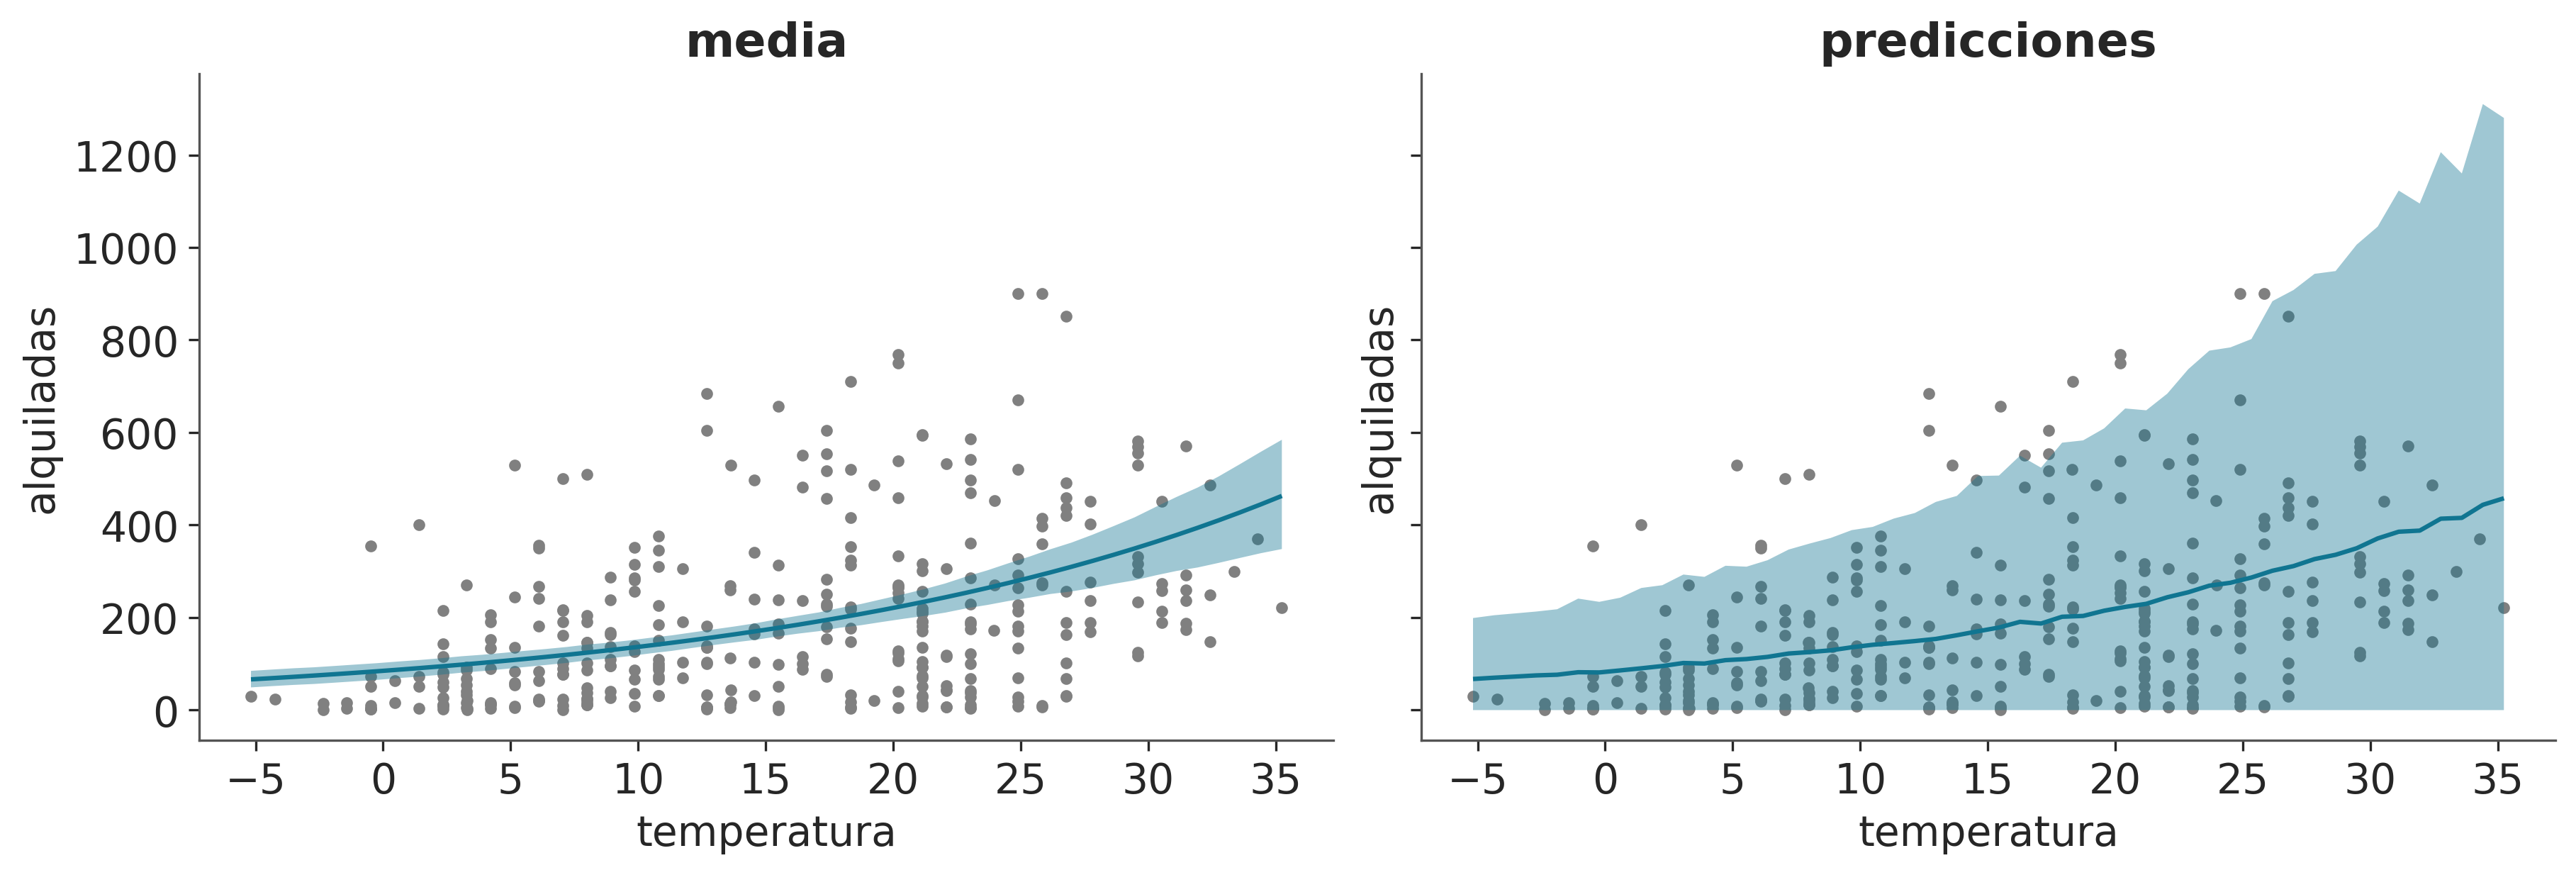

In [14]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(modelo_t, idata_t, "temperatura", ax=axes[0])
bmb.interpret.plot_predictions(modelo_t, idata_t, "temperatura", pps=True, ax=axes[1])

axes[0].plot(bicis.temperatura, bicis.alquiladas, ".", color="0.5",  zorder=-3)
axes[1].plot(bicis.temperatura, bicis.alquiladas, ".", color="0.5", zorder=-3)
axes[0].set_title("media")
axes[1].set_title("predicciones");


Probemos ahora ajustar un modelo de regresión con dos variables predictoras, `temperatura` y `humedad`.

In [15]:
modelo_th = bmb.Model("alquiladas ~ temperatura + humedad", bicis, 
                     family="negativebinomial")
                     
idata_th = modelo_th.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alquiladas_alpha, Intercept, temperatura, humedad]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


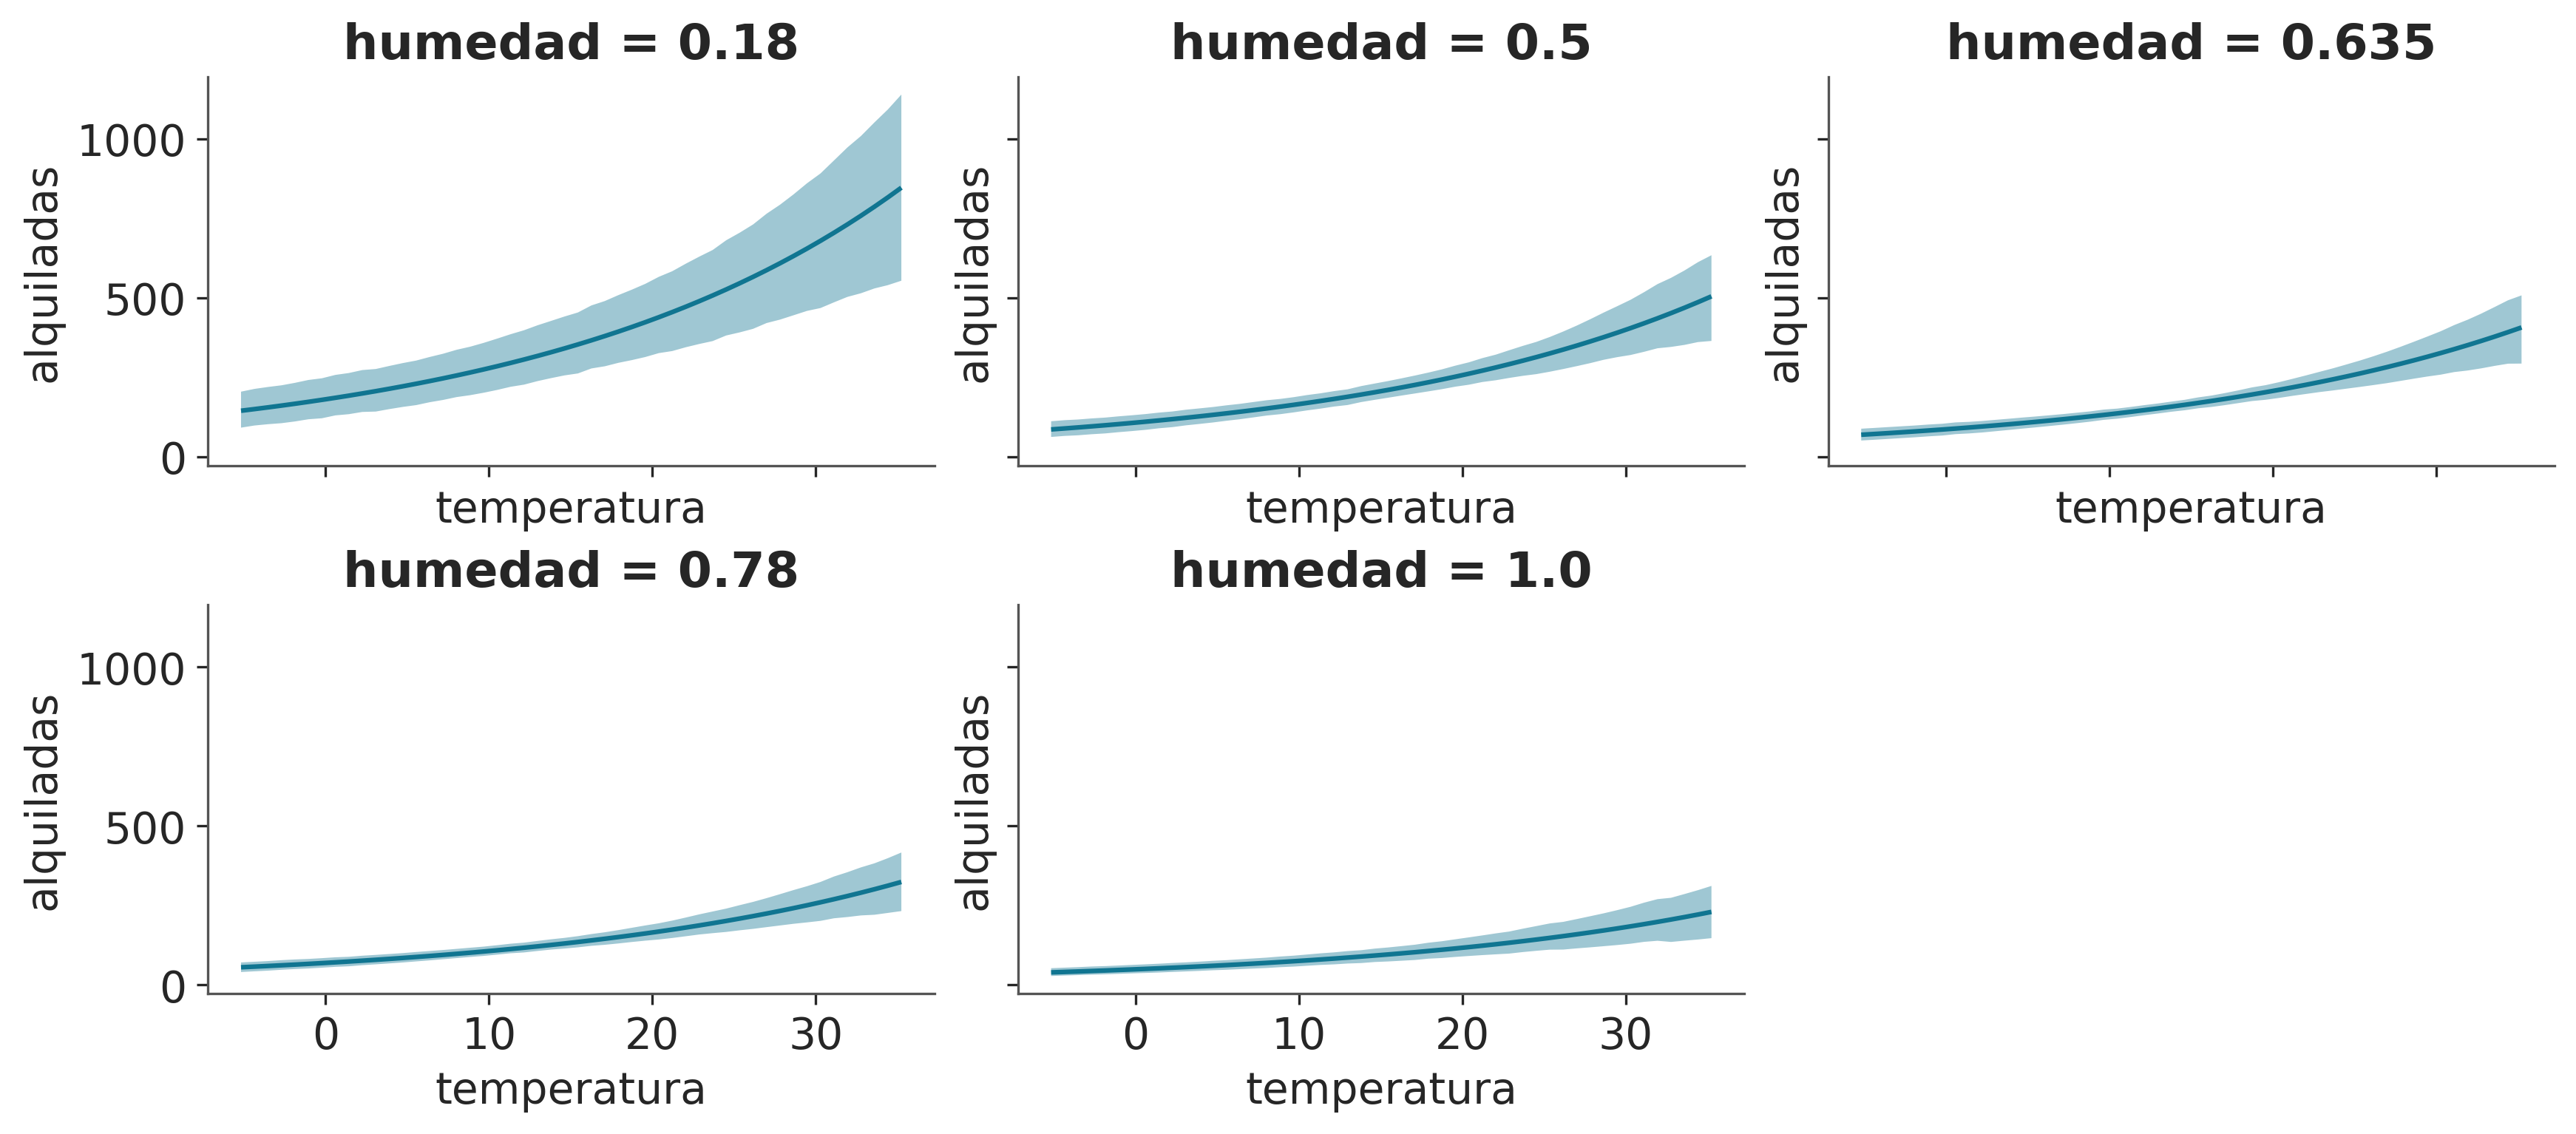

In [16]:
bmb.interpret.plot_predictions(modelo_th, idata_th, ["temperatura", "humedad"],
                               subplot_kwargs={"group":None, "panel":"humedad"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True});

En la figura anterior podemos ver que la temperatura tiene un efecto positivo en el número de bicicletas alquiladas, mientras que la humedad tiene un efecto negativo. También podemos ver que el efecto de la temperatura es más fuerte que el de la humedad.

## Regresión polinomial

Una forma de ajustar curvas usando un modelo de regresión lineal es construyendo un polinomio, como este:

$$
   \mu = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4 \dots \beta_m x^m
$$

donde $m$ es el grado del polinomio.

Hay dos cosas importantes a tener en cuenta. Primero, la regresión polinómica sigue siendo una regresión lineal; la linealidad se refiere a los coeficientes (los $\beta$s), no a las variables (los $x$s). La segunda es que simplemente estamos creando nuevas variables de la nada. La única variable observada es \texttt{x}, el resto son sólo potencias de \texttt{x}. Crear nuevas variables a partir de las observadas es un "truco" perfectamente válido al hacer regresión, a veces la transformación puede estar motivada o justificada por la teoría (como sacar la raíz cuadrada de la longitud de los bebés), pero a veces es solo una forma de ajustar una curva. La intuición con los polinomios es que para un valor dado de \texttt{x}, cuanto mayor sea el grado del polinomio, más flexible será el ajuste. Un polinomio de grado 1 es una línea, un polinomio de grado 2 es una curva que puede subir o bajar, un polinomio de grado 3 es una curva que puede subir y luego bajar (o al revés), y así sucesivamente. Note que dije "puede" porque si tenemos un polinomio de grado 3 como $\beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$ pero los coeficientes $\beta_2$ y $\beta_3$ son 0 (o prácticamente 0), entonces la curva será una línea.

Hay dos formas de definir una regresión polinómica con Bambi. Podemos escribir los polinomios *brutos*:

```python
"y ~ x + I(x ** 2) + I(x ** 3) + I(x ** 4)"
```

donde usamos la función de identidad `I` para dejar claro que queremos elevar $x$ a alguna potencia. Necesitamos esto porque el operador `**` tiene un significado especial para Bambi. Si usamos esta sintaxis, le estamos diciendo a Bambi que modele la media de $y$ como $\alpha + \beta_0 x + \beta_0 x^2 + \beta_0 x^3 + \beta_0 x^4$

Alternativamente podemos escribir

```python
"y ~ poly(x, 4)"
```

Esto también generará un polinomio de grado 4, pero los términos del polinomio serán ortogonales entre sí, lo que significa que la correlación entre los términos se reduce. Sin entrar en detalles matemáticos, esto tiene al menos dos consecuencias importantes con respecto a los polinomios *brutos*. En primer lugar, la estimación puede ser numéricamente más estable y, en segundo lugar, la interpretación de los coeficientes es diferente. En la regresión polinómica *estándar*, los coeficientes pueden ser difíciles de interpretar, ya que cambiar el valor de un coeficiente afecta a todo el polinomio. En cambio, los polinomios ortogonales permiten interpretar más claramente el efecto de cada término, ya que son independientes entre sí. Si bien la interpretación de los coeficientes es diferente, otros resultados siguen siendo los mismos. Por ejemplo, deberías obtener las mismas predicciones con ambos enfoques.

Construyamos un polinomio ortogonal de grado 4 para modelar los datos de la bicis. Para este ejemplo, usaremos la variable `hora`:

In [17]:
modelo_poly4 = bmb.Model("alquiladas ~ poly(hora, degree=4)", bicis,
                       family="negativebinomial")
idata_poly4 = modelo_poly4.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alquiladas_alpha, Intercept, poly(hora, degree=4)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Text(0, 0.5, '')

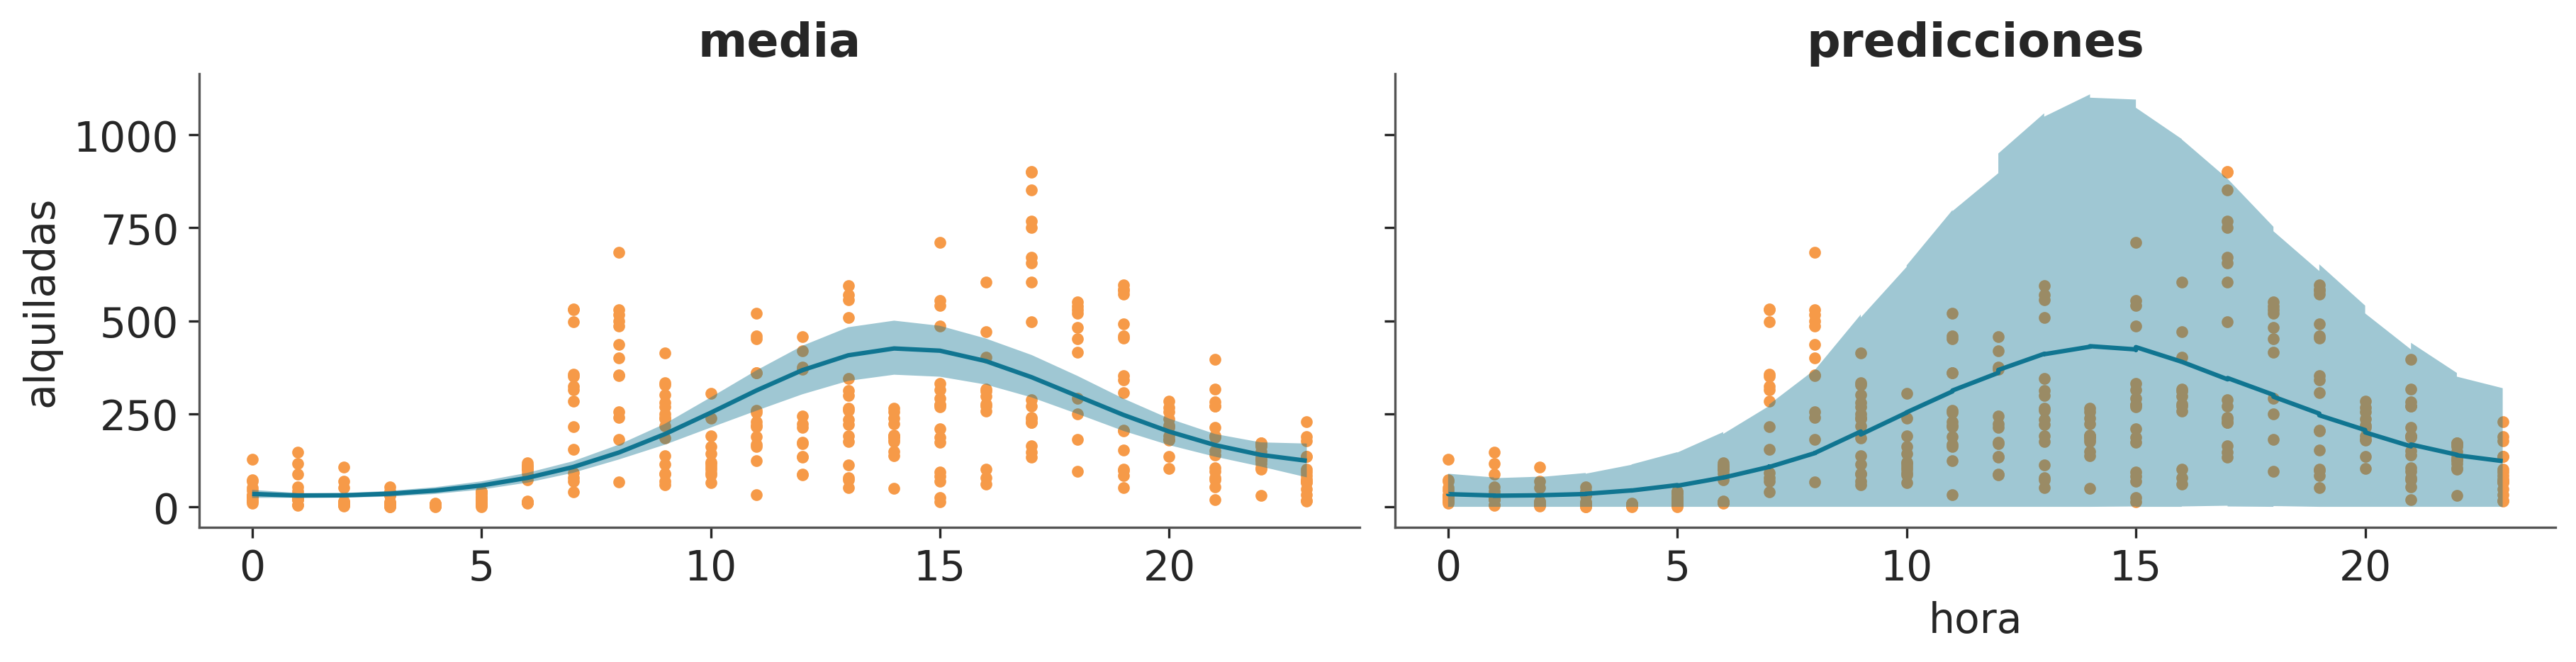

In [18]:
_, axes = plt.subplots(1, 2, sharey=True, sharex="col", figsize=(12, 3)) 
bmb.interpret.plot_predictions(modelo_poly4, idata_poly4, "hora", ax=axes[0])
bmb.interpret.plot_predictions(modelo_poly4, idata_poly4, "hora", pps=True, ax=axes[1])

for ax in axes.ravel():
    ax.plot(bicis.hora, bicis.alquiladas, "C2.", zorder=-3)
axes[0].set_title("media")
axes[1].set_title("predicciones")
axes[0].set_xlabel("")
axes[1].set_ylabel("")


Un problema con los polinomios es que actúan *globalmente*. Cuando aplicamos un polinomio de grado $m$ estamos diciendo que la relación entre las variables independientes y dependientes es de grado $m$ para todo el conjunto de datos. Esto puede resultar problemático cuando diferentes regiones de nuestros datos necesitan diferentes niveles de flexibilidad. Esto podría conducir, por ejemplo, a curvas demasiado flexibles. A medida que aumenta el grado, el ajuste se vuelve más sensible a la eliminación de puntos o, de manera equivalente, a la adición de datos futuros. En otras palabras, a medida que aumenta el grado, el modelo se vuelve más propenso a sobreajustarse. La regresión polinomial Bayesiana generalmente sufre menos de este "exceso" gracias al uso de priors y al cálculo de toda una distribución a posteriori y no una estimación puntual.

## Splines

Una forma general de escribir modelos muy flexibles es aplicar funciones $B_{m}$ a $X_{m}$ y luego multiplicarlas por coeficientes $\beta_m$:

$$
\mu = \beta_0 + \beta_1 B_{1}(X_{1}) + \beta_2 B_{2}(X_{2}) + \cdots + \beta_m B_{m}(X_{m})
$$

Somos libres de elegir las funciones $B_{m}$, por ejemplo, podemos elegir polinomios. Una opción popular es usar B-splines, no vamos a discutir su definición, pero podemos pensar en ellos como una forma de crear curvas suaves de tal manera que obtengamos flexibilidad, como con los polinomios, pero menos propensos al sobreajuste. Los B-splines son polinomios por partes, es decir, polinomios que están restringidos a afectar solo una parte de los datos. La siguiente figura muestra 3 ejemplos de polinomios por partes de grado creciente. Las líneas verticales punteadas muestran los "nudos", que son los puntos utilizados para restringir las regiones, la línea gris discontinua representa la función que queremos aproximar y las líneas negras son los polinomios por partes.


![](img/piecewise.png)


La siguiente figura muestra ejemplos de splines de grado 1 y 3, los puntos en la parte inferior representan los nudos y las líneas discontinuas son los B-splines. En la parte superior tenemos todos los B-splines con igual peso, usamos una escala de grises para resaltar que tenemos muchos B-splines. En el panel inferior, cada B-splines tiene un peso diferente (los multiplicamos por coeficientes $\beta_m$), si sumamos los B-splines ponderados obtenemos como resultado la línea negra. Esta línea negra es lo que solemos llamar "la spline". Podemos utilizar la estadística Bayesiana para encontrar los pesos adecuados para los B-splines.


![](img/splines_weighted.png)


Podemos usar B-splines con Bambi usando la función `bs`. Por ejemplo, ajustemos un spline de grado 3 a los datos de las bicis:



In [19]:
num_knots = 6
knots = np.linspace(0, 23, num_knots+2)[1:-1]
modelo_spline = bmb.Model("alquiladas ~ bs(hora, degree=3, knots=knots)", bicis,           
                         family="negativebinomial")
idata_spline = modelo_spline.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alquiladas_alpha, Intercept, bs(hora, degree=3, knots=knots)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


En la siguiente figura podemos ver que el número de bicicletas de alquiler es el más bajo a altas horas de la noche. Luego se produce un aumento, probablemente cuando la gente se despierta y va al trabajo, a la escuela u otras actividades. Tenemos un primer pico alrededor de la hora 8, luego un ligero descenso, seguido por el segundo pico alrededor de la hora 18, probablemente porque la gente regresa a casa, después del cual hay un descenso constante. Observe que la curva no es muy suave, esto se debe a que los datos están discretizados (por hora).

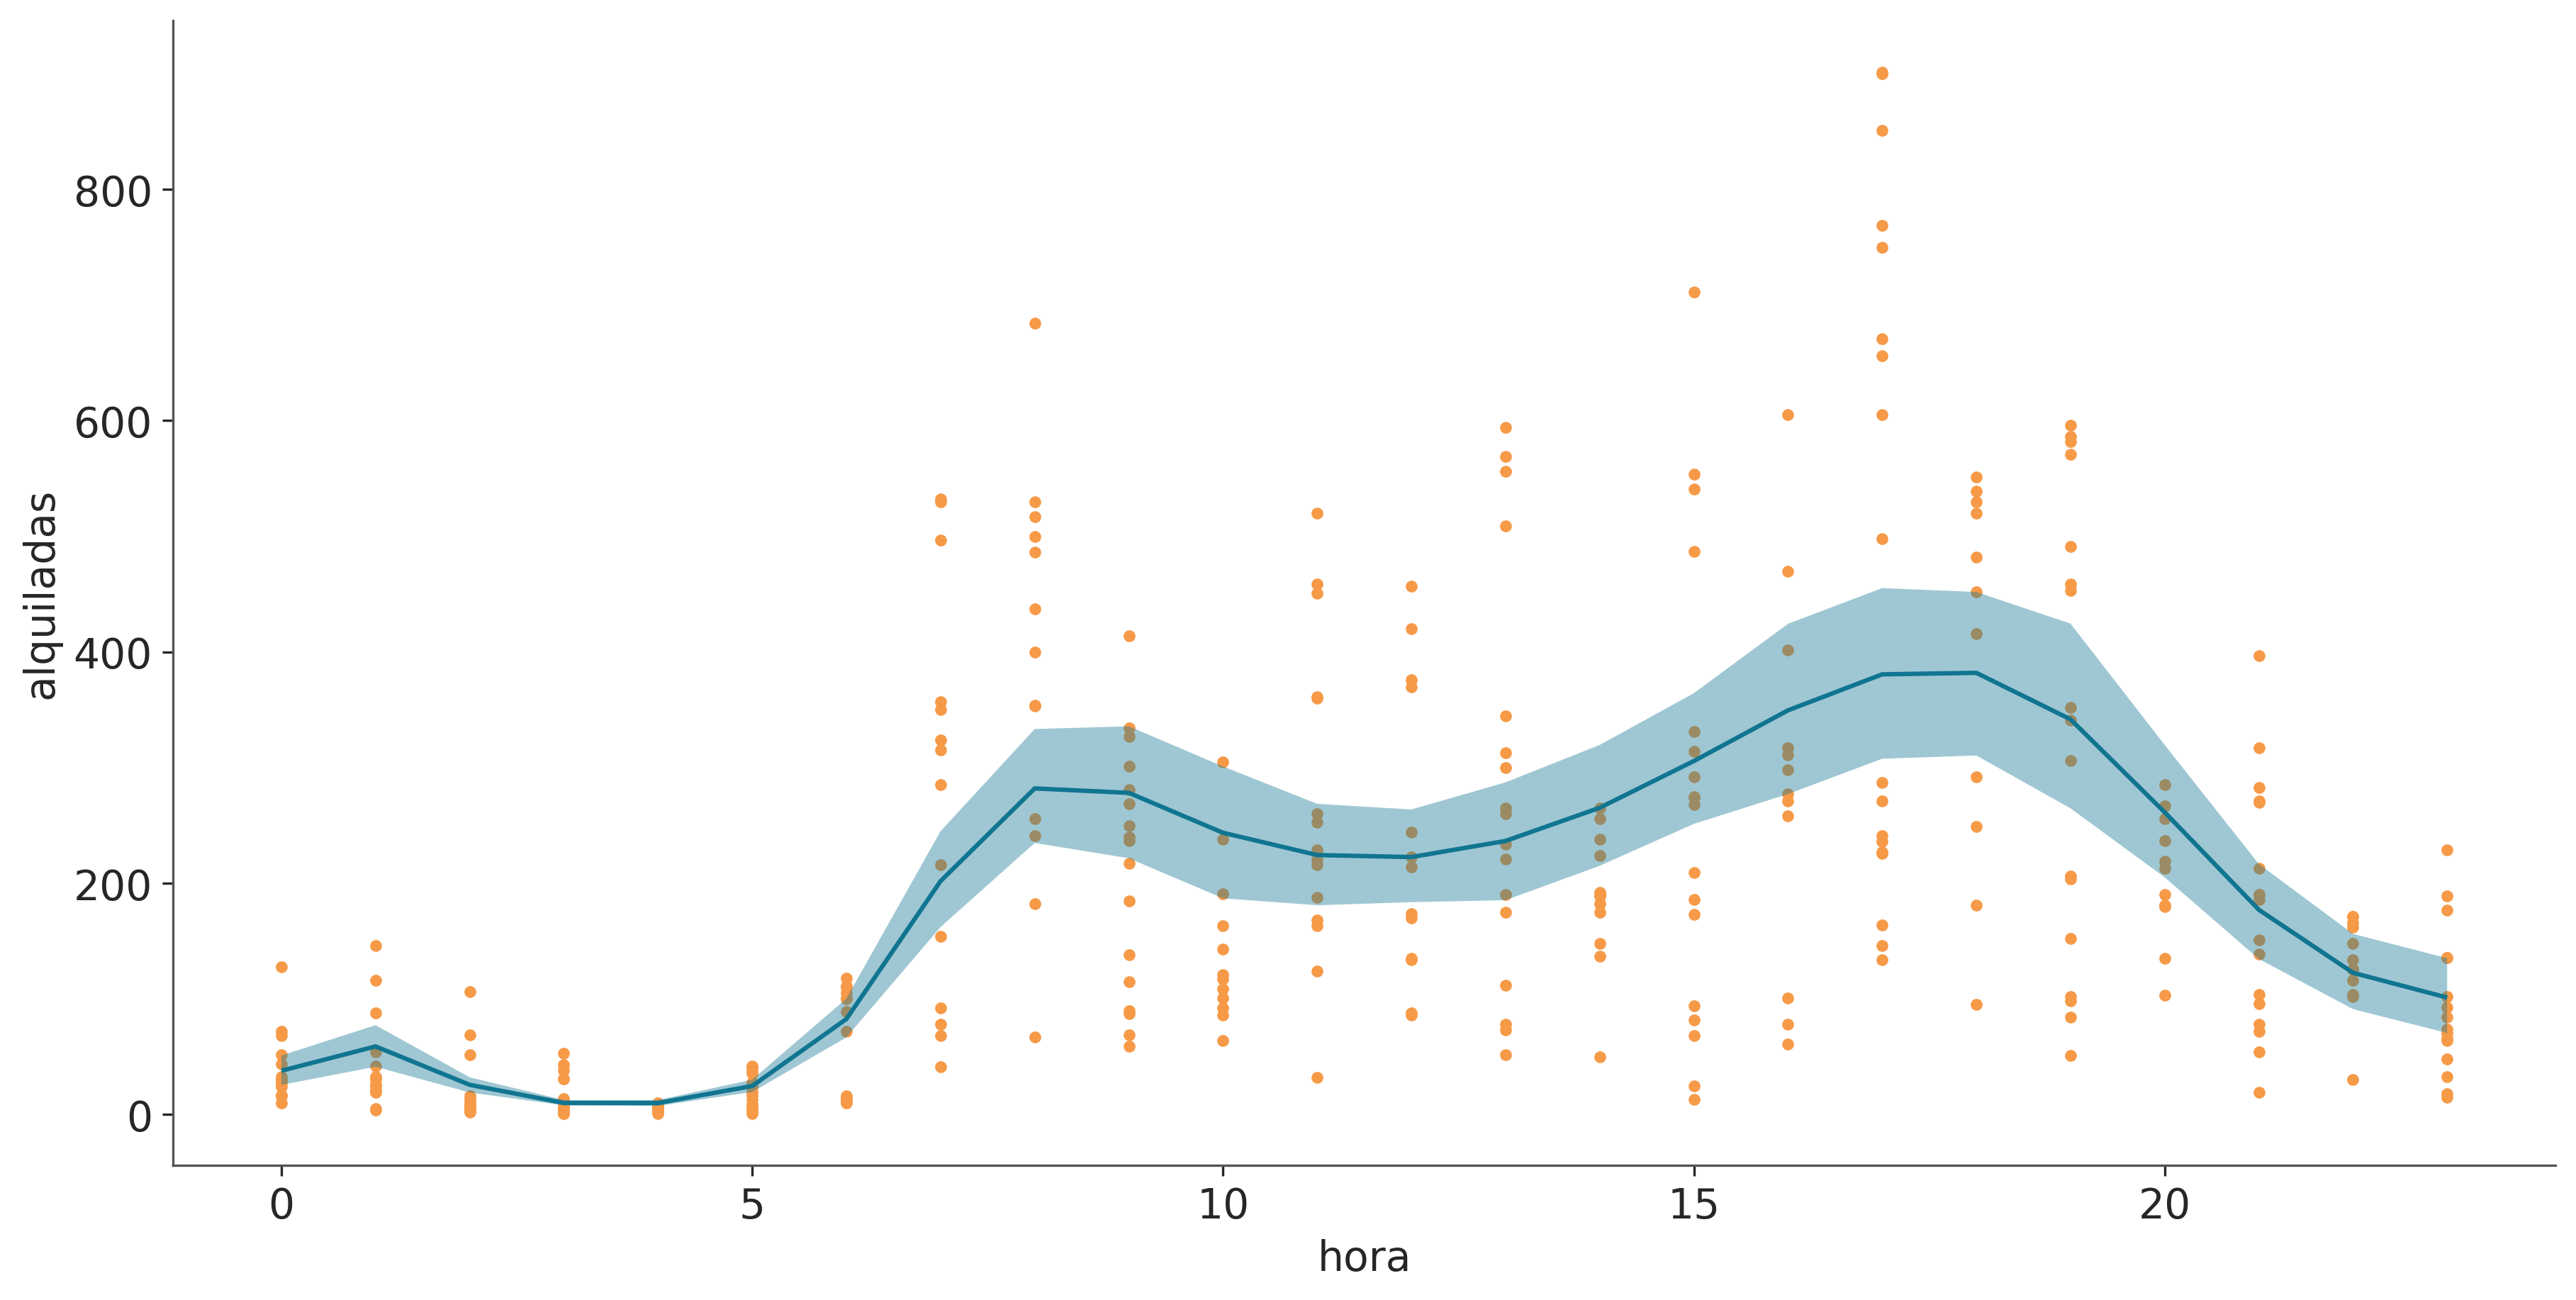

In [20]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
bmb.interpret.plot_predictions(modelo_spline, idata_spline, "hora", ax=ax)
ax.plot(bicis.hora, bicis.alquiladas, "C2.", zorder=-3)

Cuando trabajamos con splines, una decisión importante es determinar el número y la ubicación de los nudos. Esto puede ser una tarea algo desalentadora ya que el número óptimo de nudos y su espaciado no son evidentes de inmediato. Una sugerencia útil para determinar las ubicaciones de los nudos es considerar colocarlos según cuantiles en lugar de hacerlo de manera uniforme. Por ejemplo `nudos = np.quantile(bicis.hora, np.linspace(0, 1, num_knots))`. Al hacerlo, colocaríamos más nudos en áreas donde tenemos una mayor cantidad de datos, y menos nudos en áreas con menos datos. Esto da como resultado una aproximación más adaptable que captura efectivamente la variabilidad en regiones con una mayor densidad de puntos de datos. Además, es posible que deseemos ajustar splines con distintos números de nudos y posiciones y luego evaluar los resultados, utilizando herramientas como LOO, como veremos en el próximo capítulo.

## Modelos distribucionales

Anteriormente vimos que podemos usar modelos lineales para parámetros distintos de la media. Por ejemplo, podemos utilizar un modelo lineal para la media y un modelo lineal para la desviación estándar de una distribución Gaussiana. Estos modelos suelen denominarse modelos distribucionales. La sintaxis de Bambi para los modelos distribucionales es muy similar, sólo necesitamos agregar una línea para los parámetros auxiliares que queremos modelar. Por ejemplo, sigma para una Gaussiano o alfa para un NegativaBinomial

Reproduzcamos ahora un ejemplo del capítulo anterior, el ejemplo de los bebés.

In [21]:
bebes = pd.read_csv('datos/babies.csv')

In [22]:
modelo_cons = bmb.Model("Longitud ~ np.sqrt(Meses)", bebes)
idata_cons = modelo_cons.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Longitud_sigma, Intercept, np.sqrt(Meses)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


En el modelo anterior sigma es constante, ahora veamos un modelo distribucional. En este modelo `sigma` es una función lineal de `Meses`.

In [23]:
formula = bmb.Formula(
    "Longitud ~ np.sqrt(Meses)",
    "sigma ~ Meses"
)
modelo_dis = bmb.Model(formula, bebes)
idata_dis = modelo_dis.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, np.sqrt(Meses), sigma_Intercept, sigma_Meses]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


En la siguiente figura podemos ver los valores a posteriori de sigma para los modelos con sigma constante y variable. Podemos ver que cuando se permite que sigma varíe obtenemos valores por debajo y por encima de la estimación para un sigma constante, lo que significa que estamos subestimando y sobreestimando este parámetro cuando no permitimos que cambie.

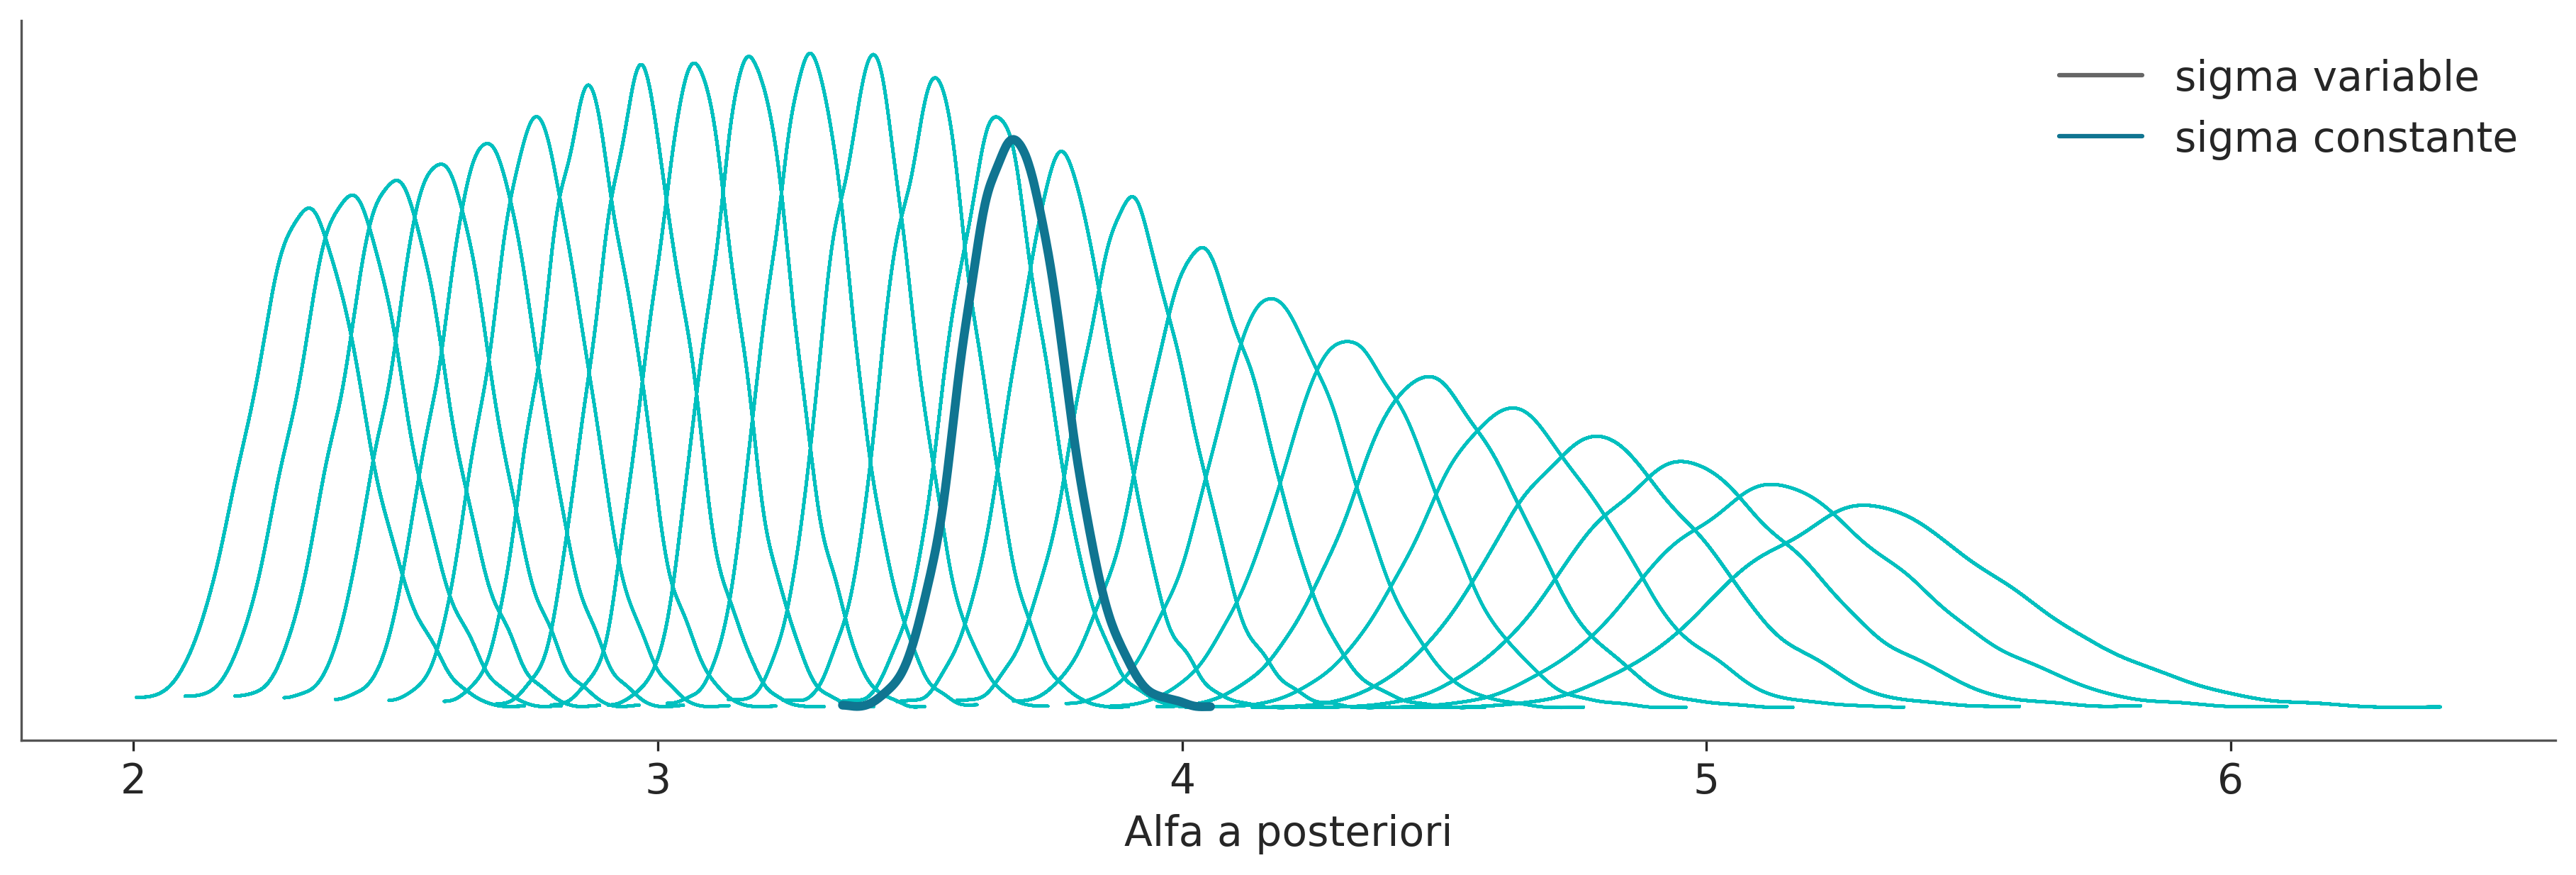

In [24]:
#| code-fold: true

fig, ax = plt.subplots(figsize=(12, 4))
from matplotlib.lines import Line2D

for idx in idata_dis.posterior.coords.get("Longitud_obs"):
    values = idata_dis.posterior["sigma"].sel(Longitud_obs=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=1, color="C1")

values = idata_cons.posterior["Longitud_sigma"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=3, color="C0")

handles = [
    Line2D([0], [0], label="sigma variable", lw=1.5, color="k", alpha=0.6),
    Line2D([0], [0], label="sigma constante", lw=1.5, color="C0")
]

legend = ax.legend(handles=handles, loc="upper right")

ax.set(xlabel="Alfa a posteriori", yticks=[]);

La siguiente figura muestra el ajuste a posteriori para `model_dis`. Observe que el modelo puede capturar el aumento de la variabilidad a medida que los bebés crecen. 

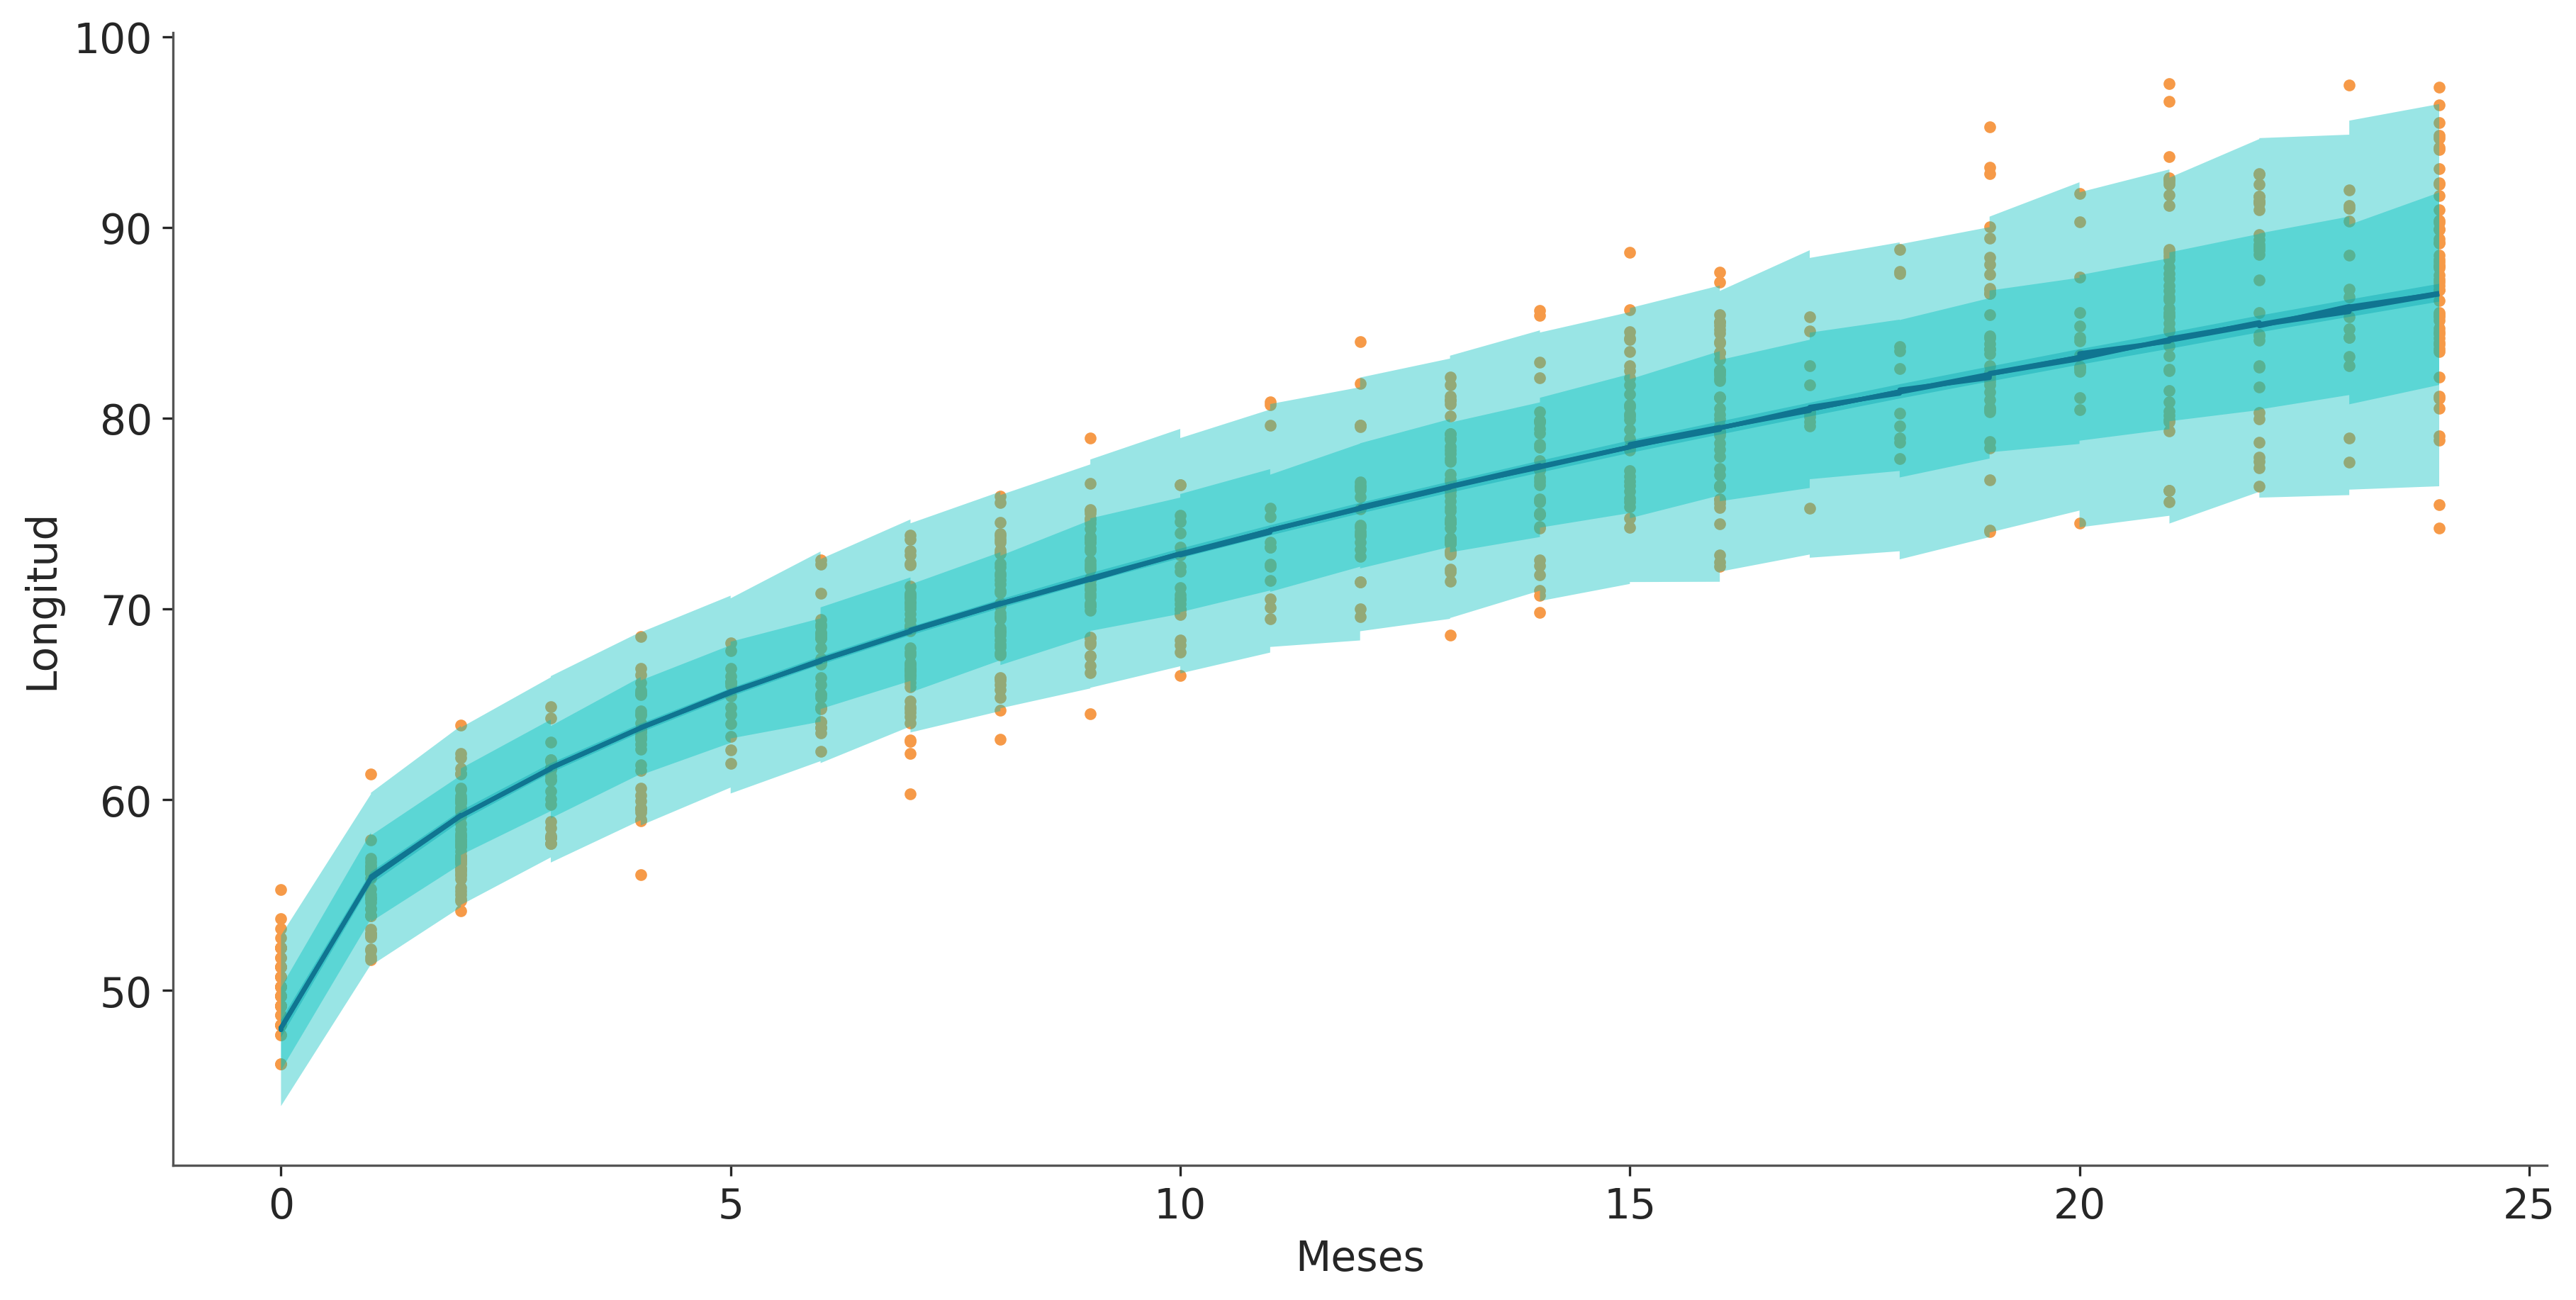

In [25]:
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6)) 
bmb.interpret.plot_predictions(modelo_dis, idata_dis, "Meses", ax=ax, fig_kwargs={"color":"k"})
bmb.interpret.plot_predictions(modelo_dis, idata_dis, "Meses", pps=True, ax=ax)
ax_ = bmb.interpret.plot_predictions(modelo_dis, idata_dis, "Meses", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')  

ax.plot(bebes.Meses, bebes.Longitud, "C2.", zorder=-3);

Al trabajar con PyMC vimos que el muestreo de la distribución predictiva a posteriori, evaluado en valores no observados, requiere que definamos el modelo con las "X" como `Mutable_data` y luego actualicemos el valor de la variable mutable antes de calcular la distribución predictiva posterior. Con Bambi esto no es necesario, podemos usar el método `predict` para predecir nuevos valores pasando los nuevos valores al argumento `data`. Por ejemplo, predigamos la longitud de un bebé a los 0,5 meses (15 días):

In [26]:
modelo_dis.predict(idata_dis, kind="pps", data=pd.DataFrame({"Meses":[0.5]}))

Esto agrega un grupo `posterior_predictive` a `idata_dis`

In [27]:
idata_dis

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

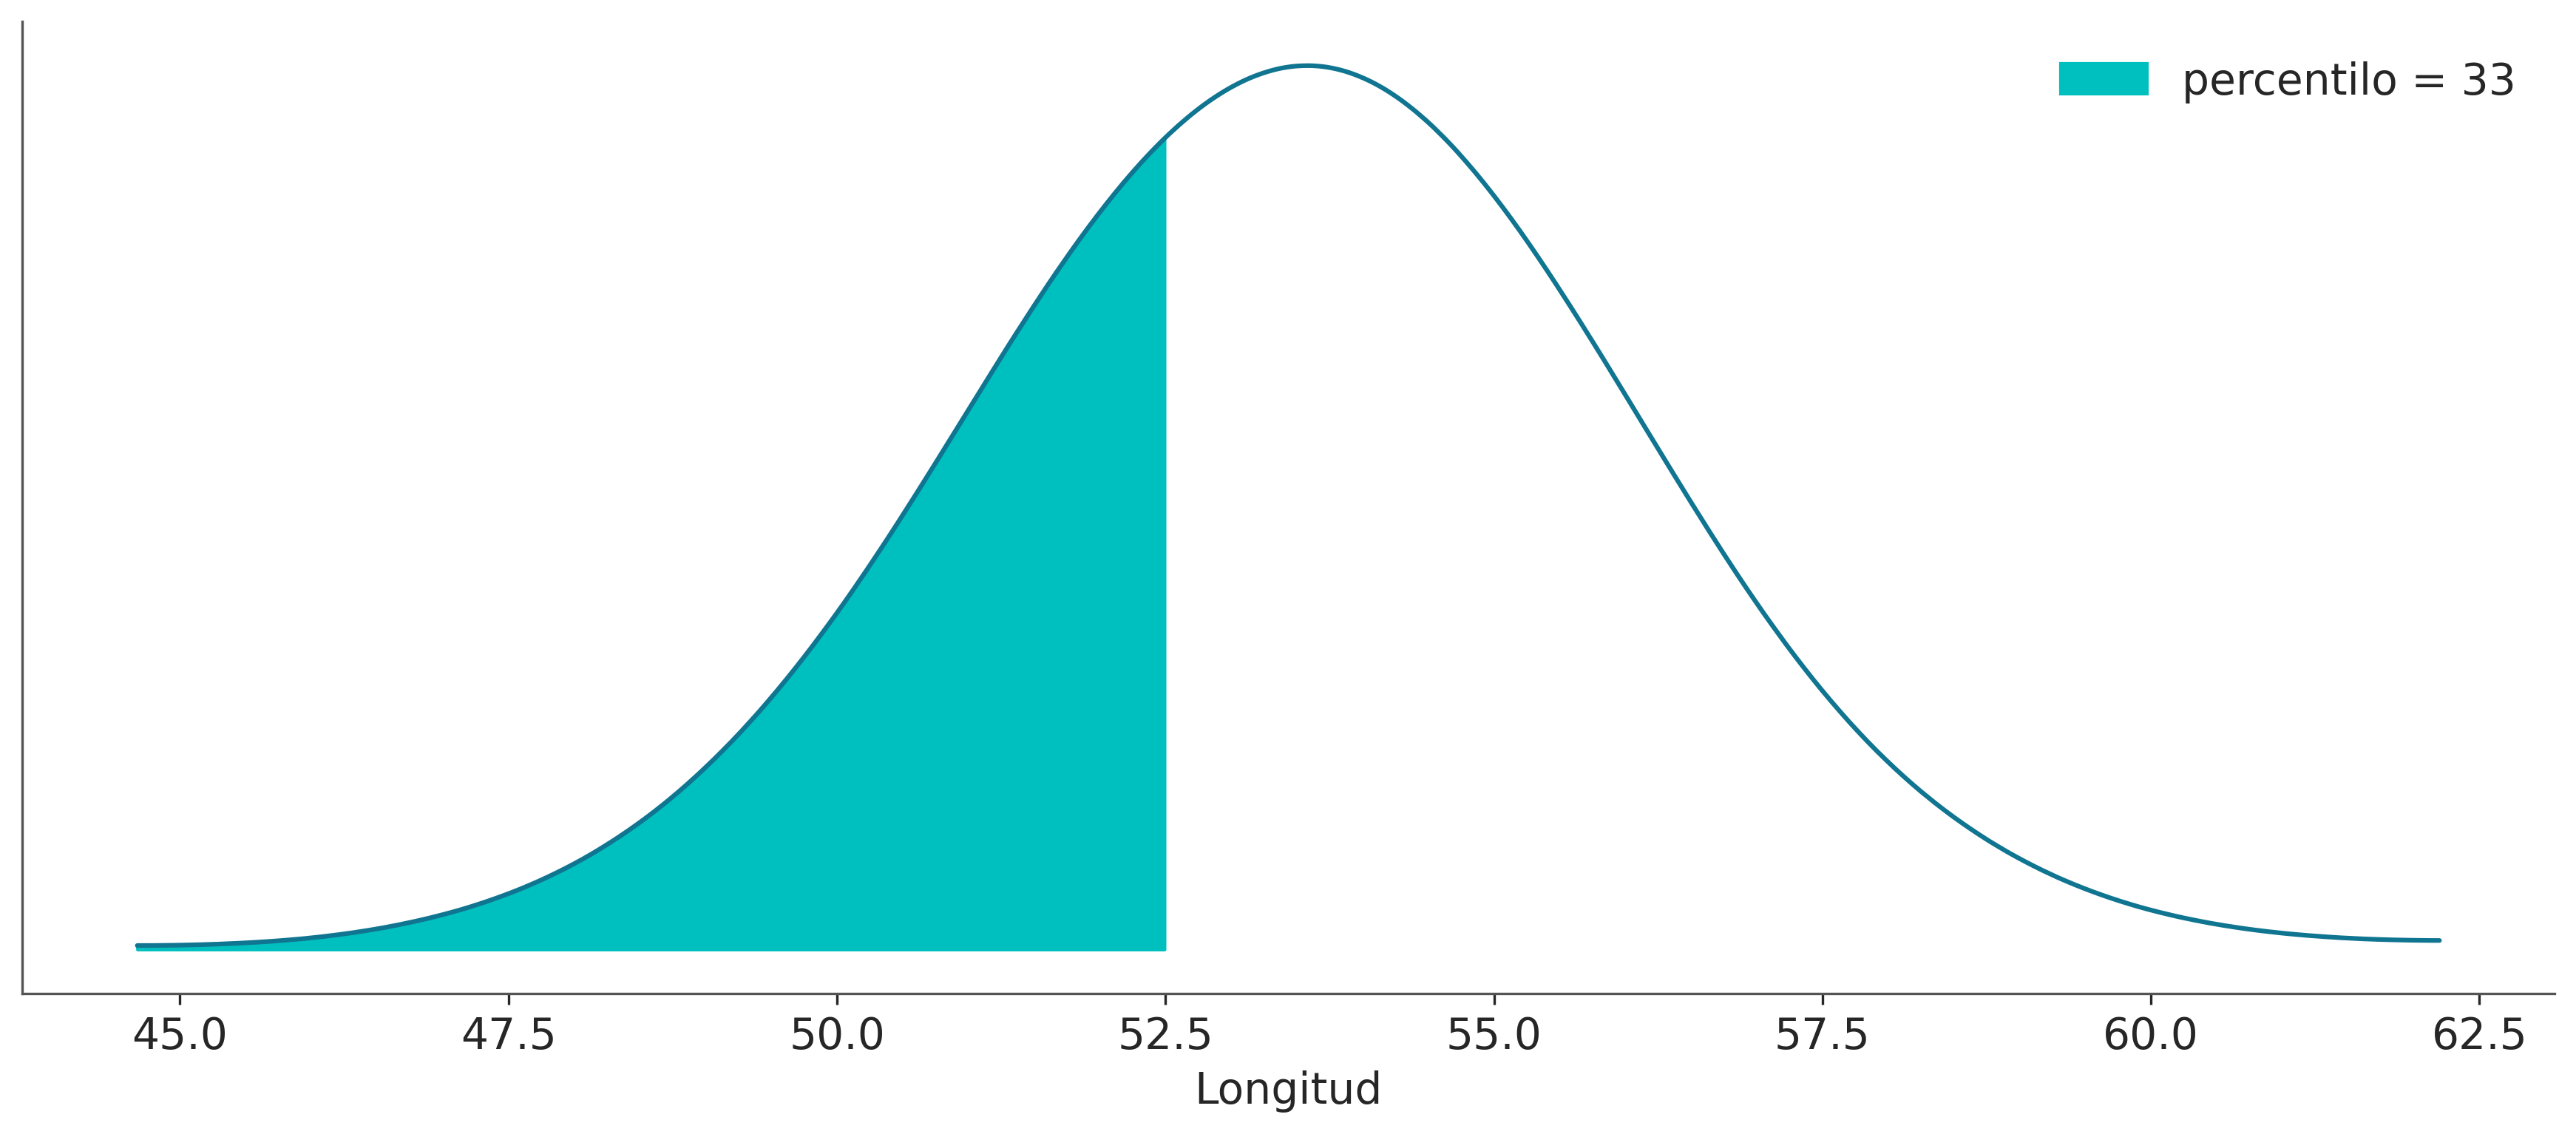

In [28]:
#| code-fold: true

ref = 52.5
y_ppc = idata_dis.posterior_predictive["Longitud"].stack(sample=("chain", "draw"))
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentilo = {:2d}".format(percentile),
    color="C1",
)
plt.xlabel("Longitud")
plt.yticks([])
plt.legend();

## Predictores Categóricos

Una variable categórica representa distintos grupos o categorías. La variable solo puede tomar un conjunto limitado de valores de esas categorías. Estos valores suelen ser etiquetas o nombres que no poseen significado numérico por sí solos. Algunos ejemplos son:

* Afiliación política: conservadora, liberal o progresista.
* Sexo: femenino o masculino.
* Nivel de satisfacción del cliente: muy insatisfecho, insatisfecho, neutral, satisfecho o muy satisfecho.


Los modelos de regresión lineal pueden acomodar fácilmente variables categóricas, solo necesitamos codificar las categorías como números. Hay algunas opciones para hacerlo. Bambi puede manejar fácilmente los detalles por nosotros. El diablo está en los detalles de como interpretamos los resultados.

### Pingüinos Categóricos

Para el ejemplo actual, vamos a utilizar el conjunto de datos de [Palmer Penguins](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0090081), que contiene 344 observaciones de 8 variables. Por el momento nos interesa modelar la masa de los pingüinos en función de la longitud de su pico. Se espera que la masa de los pingüinos aumente a medida que aumenta la longitud del pico. La novedad de este ejemplo es que vamos a considerar la variable categórica, `species`. Esta variable tiene 3 categorías o niveles, a saber, `Adelie`, `Chinstrap` y `Gentoo`. La @fig-scatter_pen muestra un diagrama de dispersión para las variables que queremos modelar.


In [29]:
#| code-fold: true

penguins = pd.read_csv("datos/penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


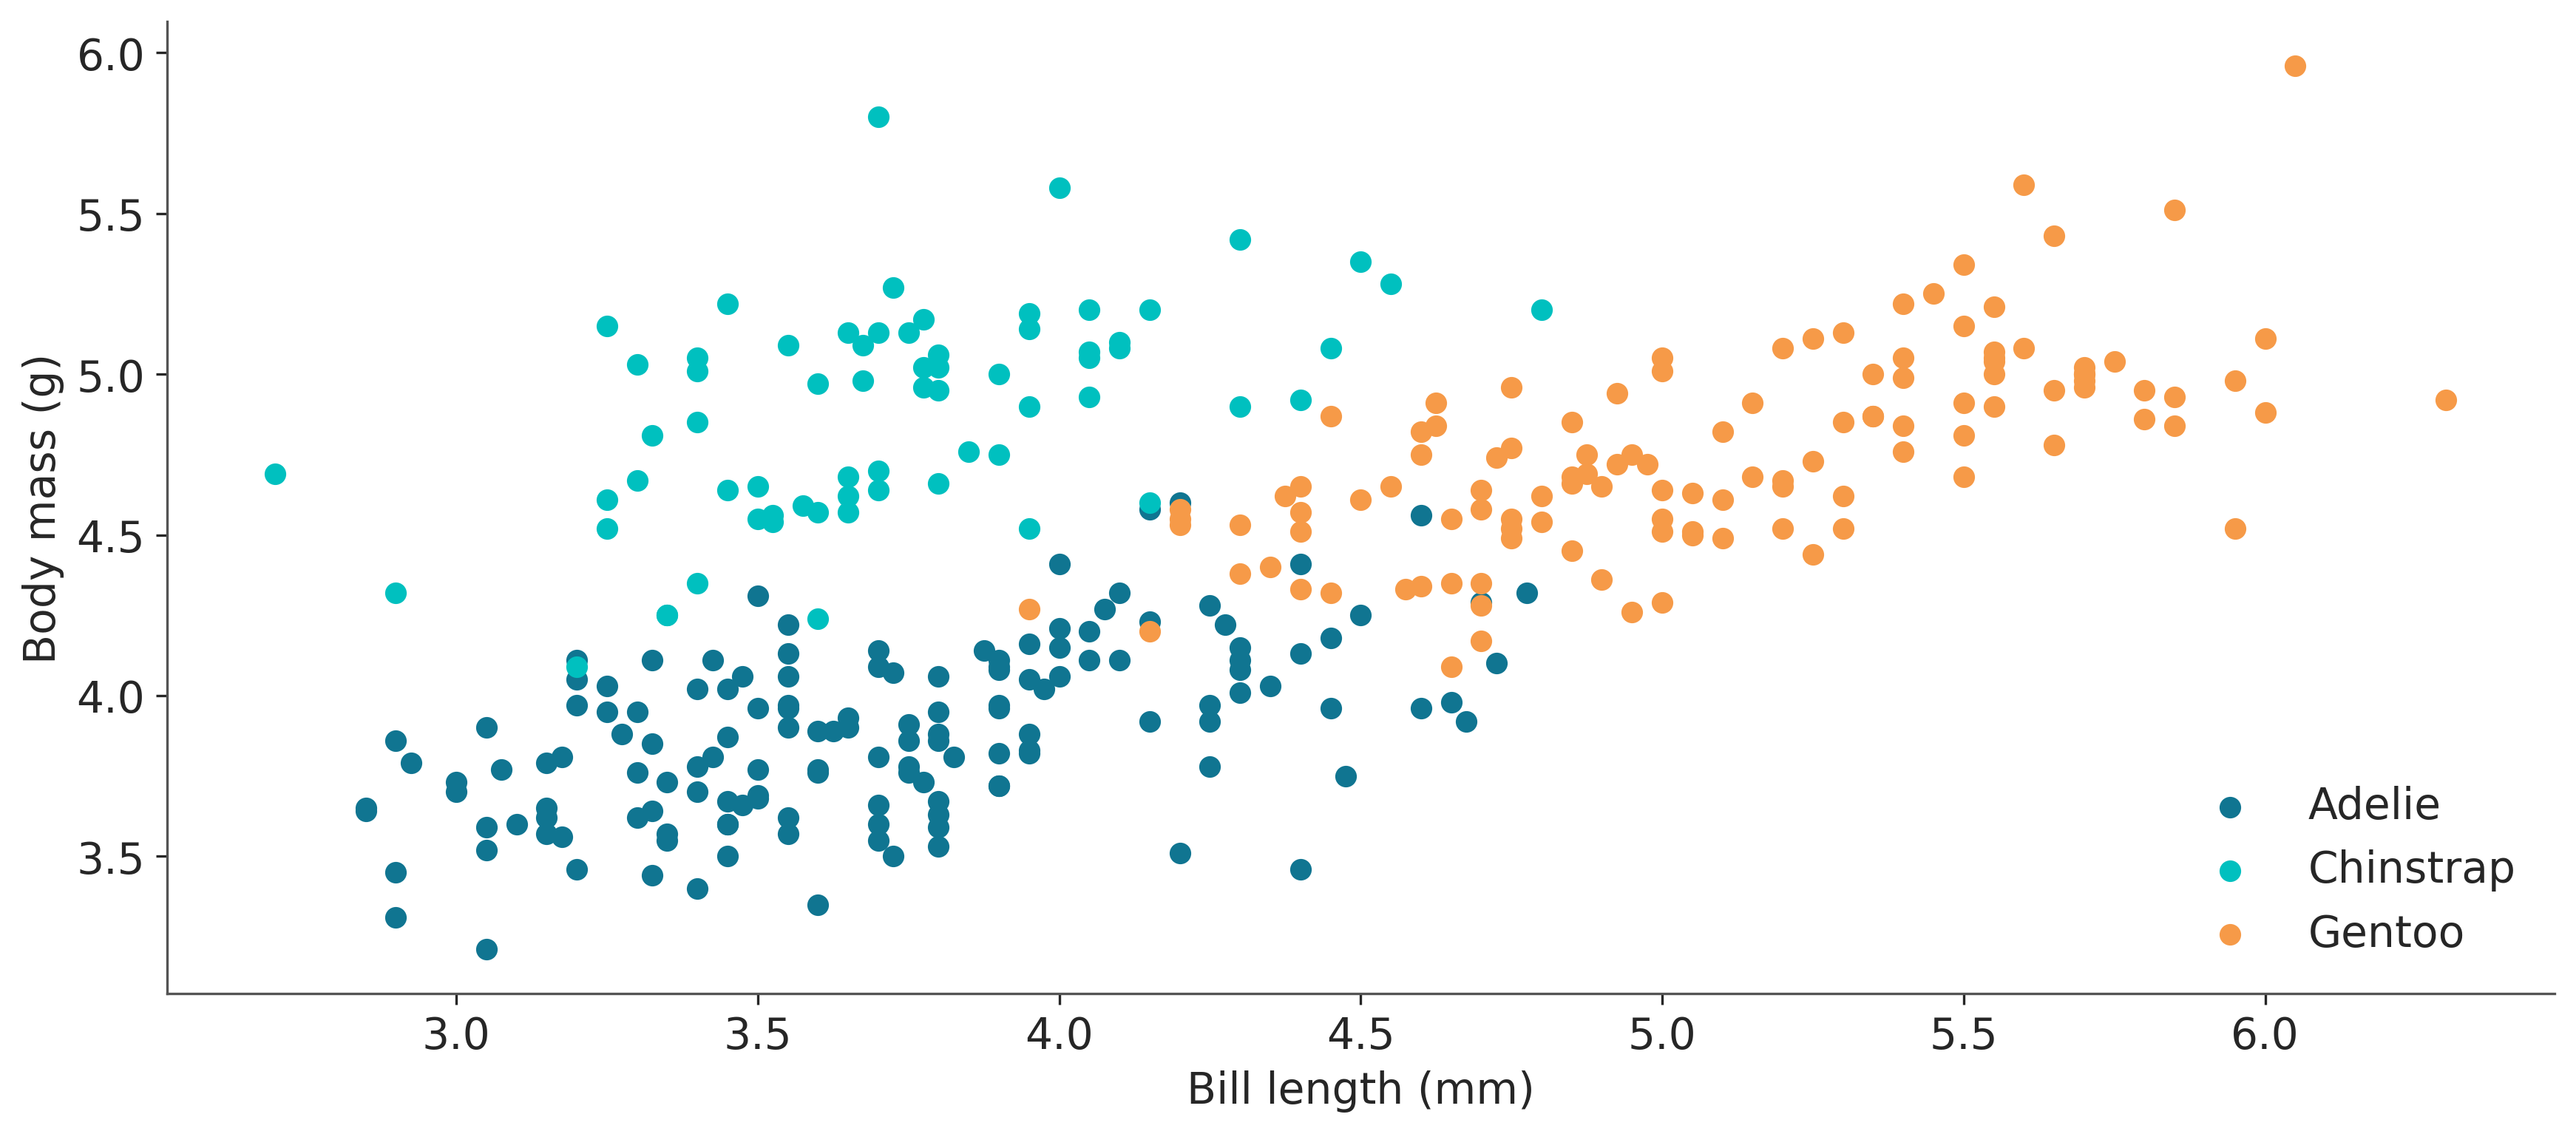

In [30]:
#| code-fold: true
#| label: fig-scatter_pen
#| fig-cap: Largo del pico (bill_length) vs masa (body_mass) para 3 especies de pingüinos.


# Get unique categories
unique_categories = np.unique(penguins.species)

# Create color map for categories
category_color_map = {cat: f"C{i}" for i, cat in enumerate(unique_categories)}

# Generate colors for each category
colors = [category_color_map[cat] for cat in penguins.species]

# Create scatter plot for each category
for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

# Add labels and legend
plt.ylabel("Body mass (g)")
plt.xlabel("Bill length (mm)")
plt.legend(labels=unique_categories, loc="lower right");

Para ajustar un modelo con variables categoricas no necesitamos de ninguna sintáxis especial

In [31]:
modelo_p = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_p = modelo_p.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_length, species]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


La @fig-penguins_posterior muestra un forest plot para `model_p`. ¿Notás algo inesperado? No hay valores posteriores para `Adelie`. Esto no es un error. De forma predeterminada, Bambi codifica variables categóricas con `N` niveles (3 especies) como `N-1` variables (2 especies). Así, los coeficientes `species-Chinstrap` y `species-Gentoo` representan deflecciones del modelo base:

$$
\text{body\_mass} = \beta_0 + \beta_1 \text{bill\_length} 
$$

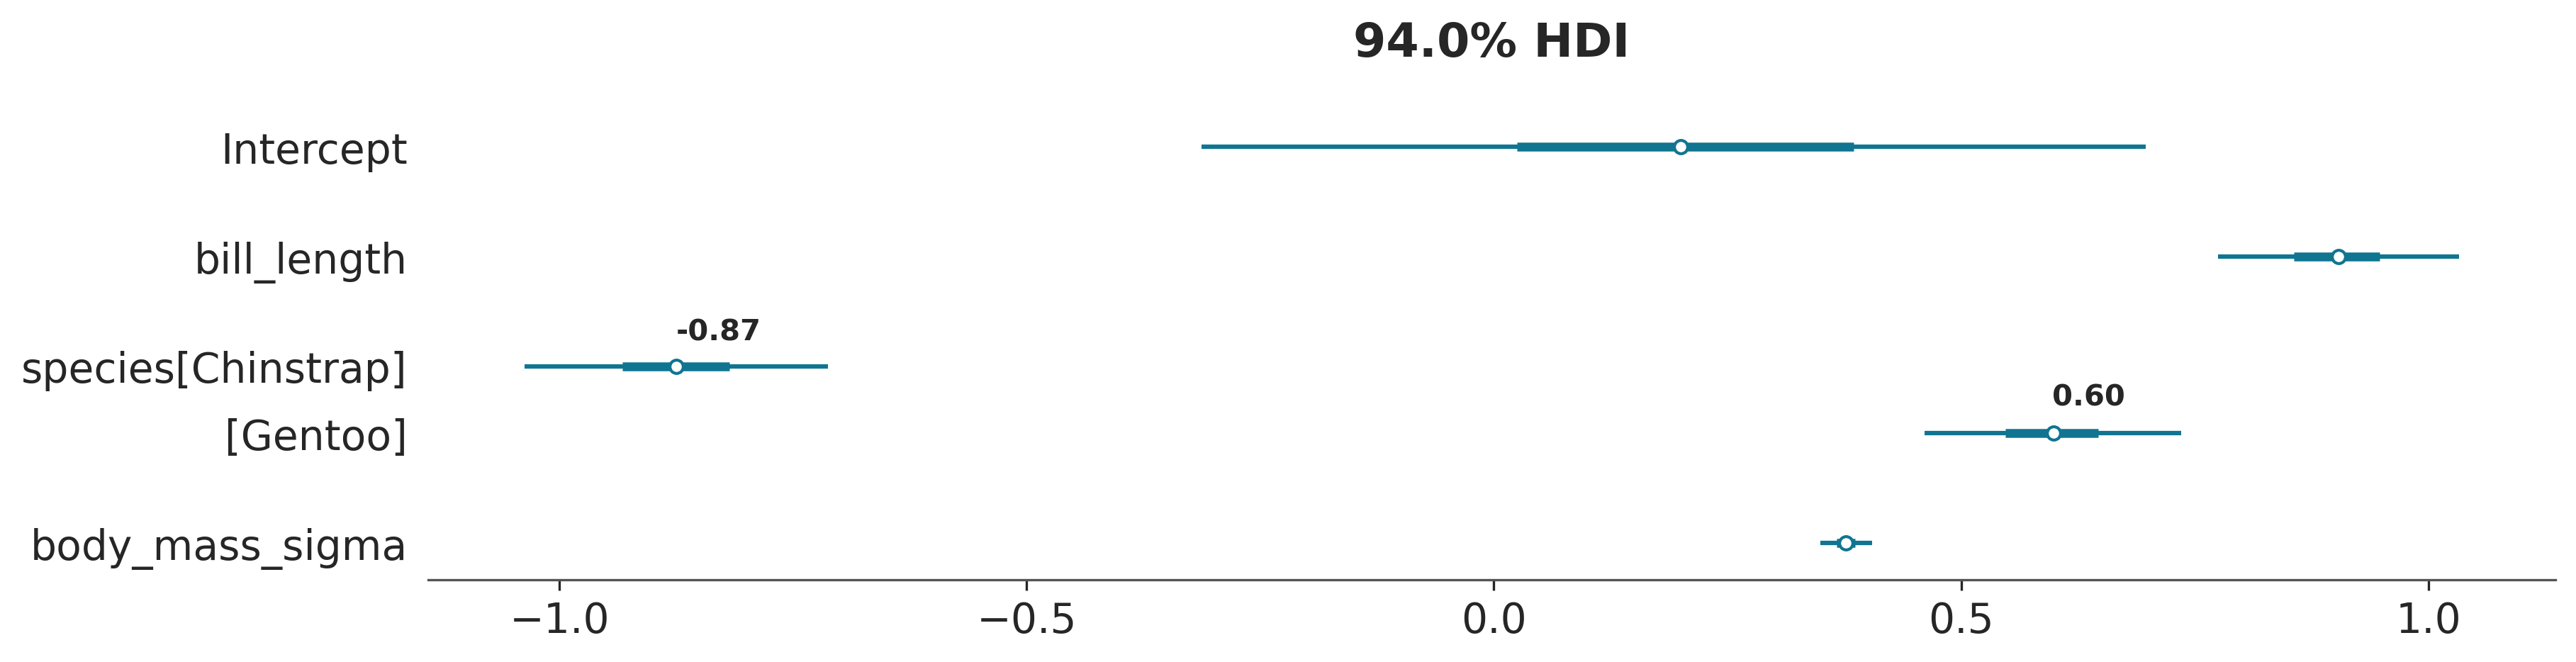

In [32]:
#| code-fold: true
#| label: fig-penguins_posterior
#| fig-cap: Fores plot para la distribución a posteriori de `modelo_p`.


ax = az.plot_forest(idata_p, combined=True, figsize=(12, 3))
mean_chinstrap = idata_p.posterior["species"].sel(species_dim="Chinstrap").mean()
mean_gentoo = idata_p.posterior["species"].sel(species_dim="Gentoo").mean()
ax[0].annotate(f"{mean_chinstrap.item():.2f}", (mean_chinstrap , 2.5), weight='bold')
ax[0].annotate(f"{mean_gentoo.item():.2f}", (mean_gentoo , 1.7), weight='bold');

Para que esto quede más claro, revisemos un par de gráficos. Podemos leer la @fig-penguins_posterior como que la masa corporal de `Chinstrap` es en promedio -0.89 respecto de la masa corporal media de `Adelie`. Lo mismo ocurre con `Gentoo`, pero esta vez tenemos que agregar 0,66 a la media del modelo base. Podés comprobar que estas dos afirmaciones son verdaderas mirando la @fig-penguins_predictions. Observá cómo las 3 líneas son esencialmente paralelas entre sí con `Adelie` en el medio, `Chinstrap` debajo (-0,89) y `Gentoo` arriba (0,58).

(<Figure size 3450x1500 with 1 Axes>,
 array([<Axes: xlabel='bill_length', ylabel='body_mass'>], dtype=object))

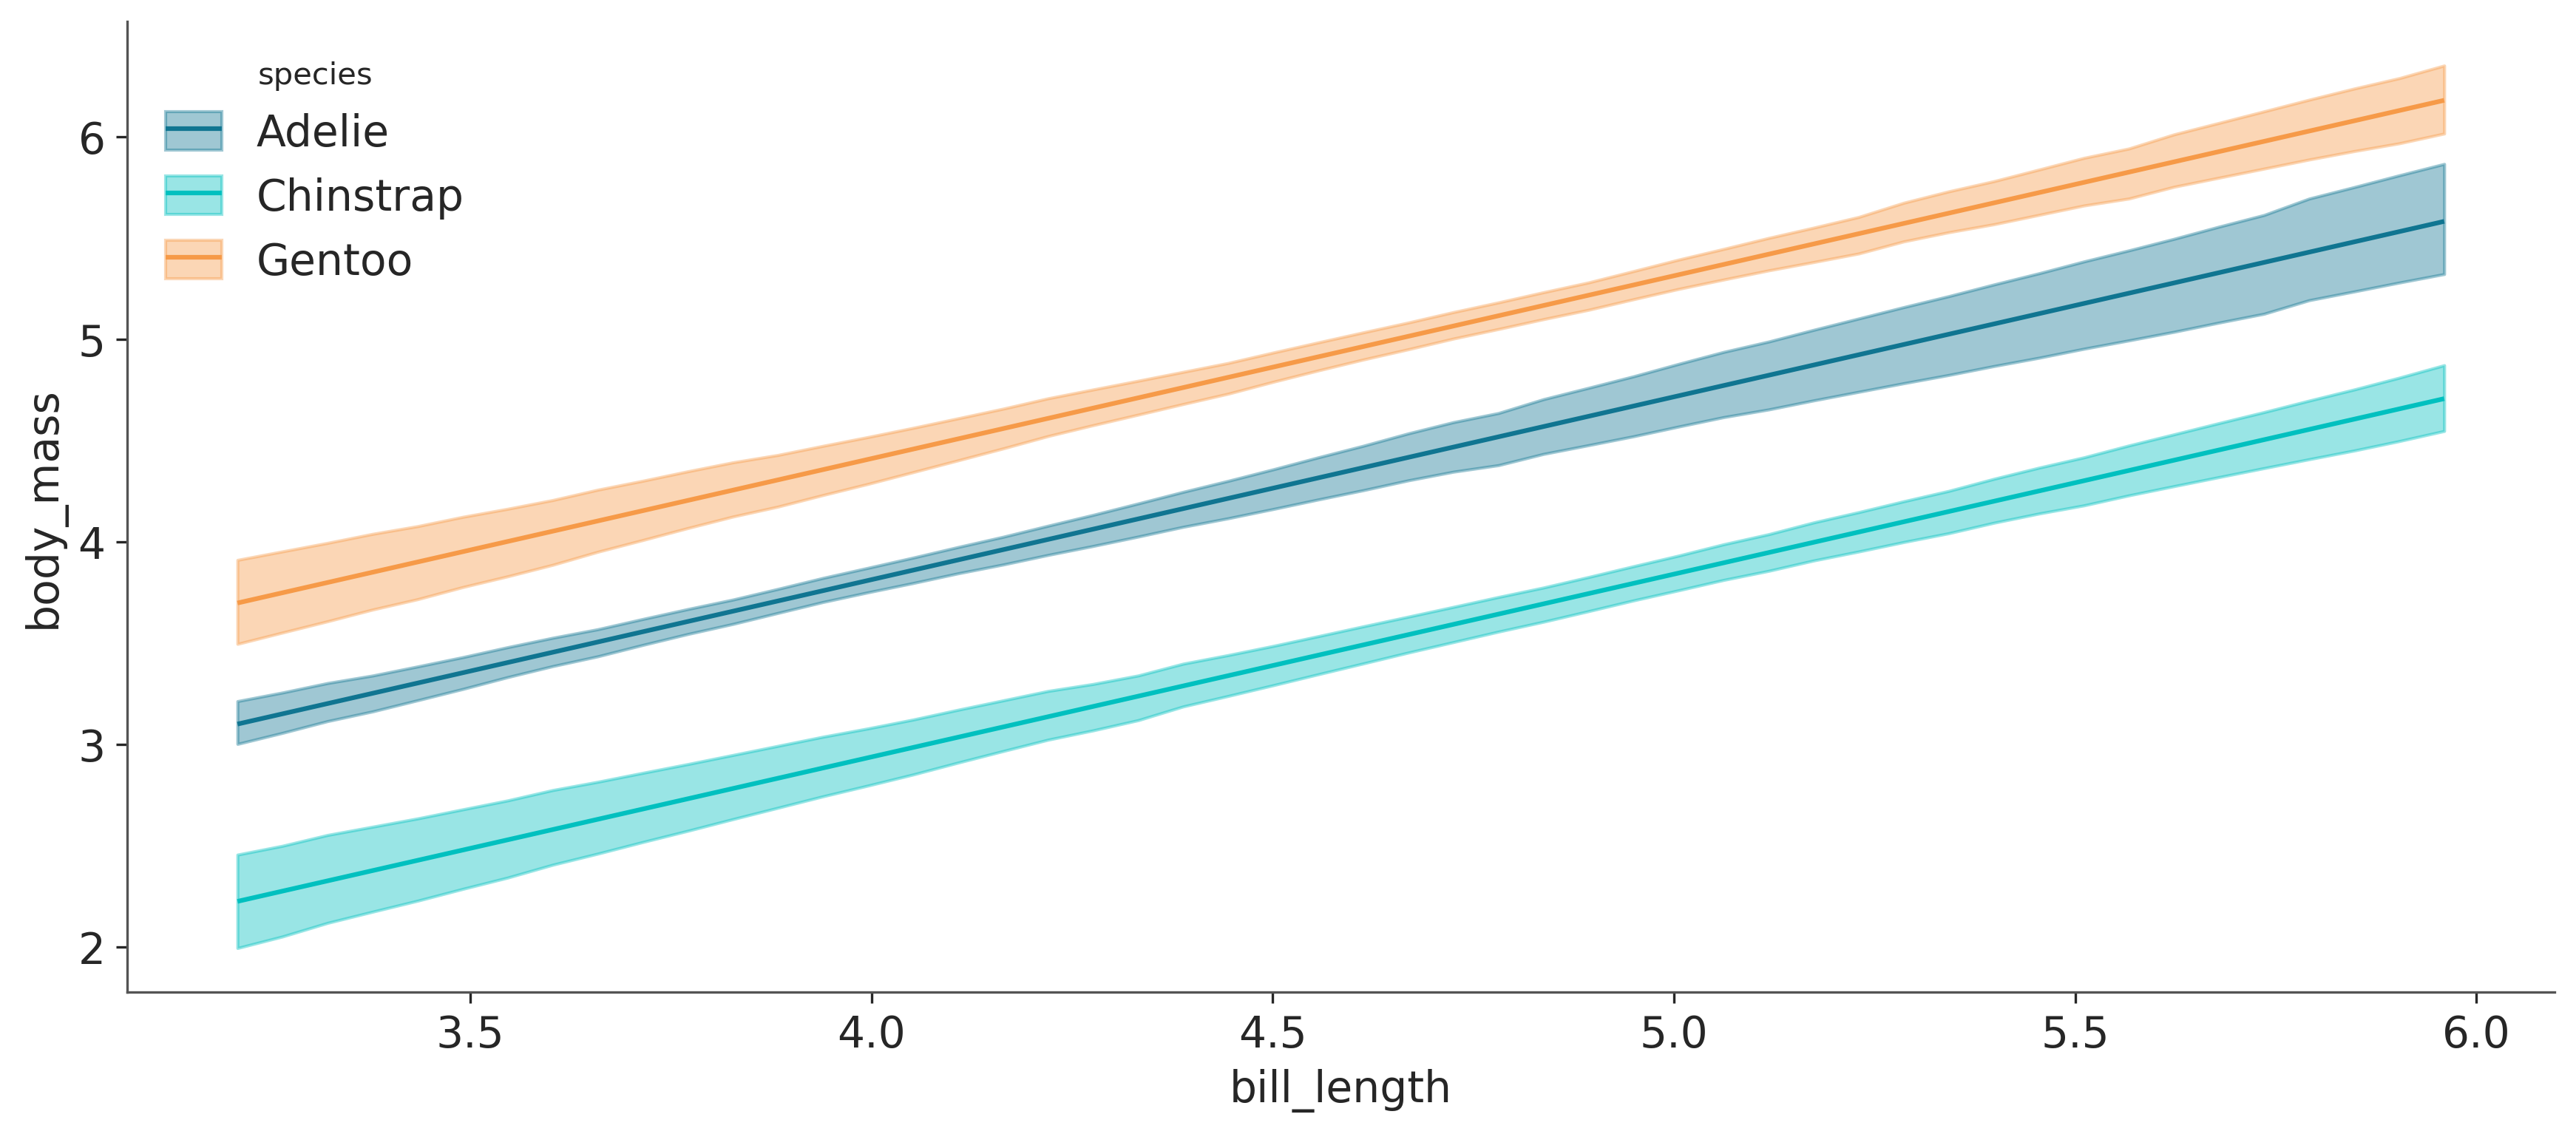

In [33]:
#| code-fold: true
#| label: fig-penguins_predictions
#| fig-cap: Predicciones del ajuste medio para `modelo_p`.


bmb.interpret.plot_predictions(modelo_p, idata_p, ["bill_length",  "species"])


### Relación con modelos jerárquicos


En el @sec-hierarchical-models analizamos y contrastamos los modelos agrupados y jerárquicos (o parcialmente agrupados). Allí mostramos que a menudo podemos aprovechar la estructura o las jerarquías de los datos. Siguiendo la lógica de ese capítulo, se podría argumentar que `Adelie`, `Gentoo` y `Chinstrap`, aunque son especies diferentes, son todos pingüinos. Por lo tanto, modelar jerárquicamente sus masas corporales puede ser una buena idea. Entonces, ¿Cuál es la diferencia entre dicho modelo y el que utilizamos en esta sección?

El factor distintivo reside en las sutilezas de los componentes de pendiente e intersección. En el caso de `model_p` (variables categóricos), la pendiente sigue siendo la misma en las tres especies de pingüinos, mientras que los interceptos pueden variar. `Intercept + 0` para `Adelie`, `Intercept + species[Chinstrap]` para Chinstrap, y `Intercept + species[Gentoo]` para `Gentoo`. Por lo tanto, este modelo resalta los distintos incerceptos manteniendo la pendiente uniforme.

Si, en cambio, hubiéramos construido el modelo jerárquico `body_mass ~ bill_length|species)`, habríamos estado pidiendo una pendiente y un intercepto parcialmente agrupados. Y si en lugar de eso hubiéramos modelado `body_mass ~ (0 + bill_length | specie)` habríamos estado pidiendo una pendiente parcialmente agrupada y un intercepto común.

Entonces, ¿Cuál es mejor modelo? Como siempre, depende, incluso en algunos casos podría ser mejor una combinación de ambos enfoques, ya que no son ideas mutuamente excluyentes. Como ya comentamos, el *mejor* modelo es el que se alinea con los objetivos de tu análisis y proporciona información útil. A menudo es una buena idea explorar múltiples modelos, comparar su desempeño usando criterios apropiados (como los discutidos en el @sec-model_comparison y considerar las implicaciones prácticas de cada modelo  en el contexto de la investigación o proceso de toma de decisiones.

## Interacciones

Un efecto de interacción o interacción estadística, ocurre cuando el efecto de una variable independiente sobre la respuesta cambia dependiendo del valor de otra variable independiente en el mismo modelo. Una interacción puede ocurrir entre dos o más variables. Algunos ejemplos son:


* Eficacia de los medicamentos y edad: un medicamento que funciona mejor en personas mayores que en personas más jóvenes
* Nivel de educación e impacto en los ingresos: Es posible que la educación superior tenga un efecto positivo más fuerte en los ingresos de un género en comparación con el otro, lo que resulta en una interacción entre la educación y el género.
* Efectos del ejercicio y la dieta sobre la pérdida de peso: Podría ser que el efecto de la dieta sobre la pérdida de peso sea pequeño para las personas que hacen nada o poco ejercicio y muy importante para las personas que hacen ejercicio moderado.
* *Temperatura y humedad para el crecimiento de los cultivos: El efecto de la temperatura y la humedad en el crecimiento de los cultivos puede depender del tipo de cultivo que se esté cultivando. Algunos cultivos podrían prosperar en condiciones cálidas y húmedas, mientras que otros podrían funcionar mejor en ambientes más fríos y menos húmedos, creando una interacción entre temperatura, humedad y tipo de cultivo.


Tenemos una interacción cuando el efecto combinado de dos o más variables actuando conjuntamente no es igual a la suma de sus efectos individuales. Si tenemos un modelo como 

$$
\mu = \alpha + \beta_0 X_0 + \beta_1 X_1
$$

no podemos modelar un interacción, ya que los efectos son aditivos. La forma más común de modelar una interacción es multiplicando 2 o más variables. Por ejemplo en un modelo como:

$$
\mu = \alpha + \overbrace{\beta_0 X_0 + \beta_1 X_1 }^{\text{término principal}} \; + \underbrace{\beta_3 X_0X_1}_{\text{término de interacción}} 
$$

Es común que al modelar una interacción se incluya también el término principal.

> Multiplicar dos variables puede verse como un truco similar al que usamos para la regresión polinómica (o cualquier transformación de una variable determinada). En lugar de multiplicar un predictor consigo mismo, multiplicamos dos predictores diferentes y obtenemos uno nuevo.


Definir una interacción es fácil; para un modelo PyMC, solo necesitamos multiplicar los dos predictores y agreagar un coeficiente más al modelo. Para que un modelo de Bambi es aún más fácil, usamos el operador `:`. Veamos un ejemplo de un modelo con y sin interacciones.




In [34]:
# Sin interacción
model_noint = bmb.Model("body_mass ~ bill_depth + bill_length", data=penguins)
idata_noint = model_noint.fit()

# COn interacción
model_int = bmb.Model("body_mass ~ bill_depth + bill_length + bill_depth:bill_length", data=penguins)
idata_int = model_int.fit()
                    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_sigma, Intercept, bill_depth, bill_length, bill_depth:bill_length]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


En la @fig-interaction_vs_noninteraction tenemos el ajuste de regresión media para `bill_depth` evaluado en 5 valores fijos de `bill_length`. A la izquierda tenemos el resultado dpara `model_noint` (sin interacciones) y a la derecha para `model_int` (con interacciones). Podemos ver que cuando no tenemos interacciones las rectas ajustadas para `bill_ depth` son paralelas en diferentes niveles de `bill_length`. En cambio, cuando tenemos interacciones las rectas ya no son paralelas, precisamente porque el efecto de cambiar `bill_depth` sobre cuánto cambia `body_mass` ya no es constante sino que está modulado por los valores de `bill_length`. Si generás una figura como @fig-interaction_vs_noninteraction, pero fijando `bill_depth` en vez de `bill_length` observarás un fenómeno parecido.

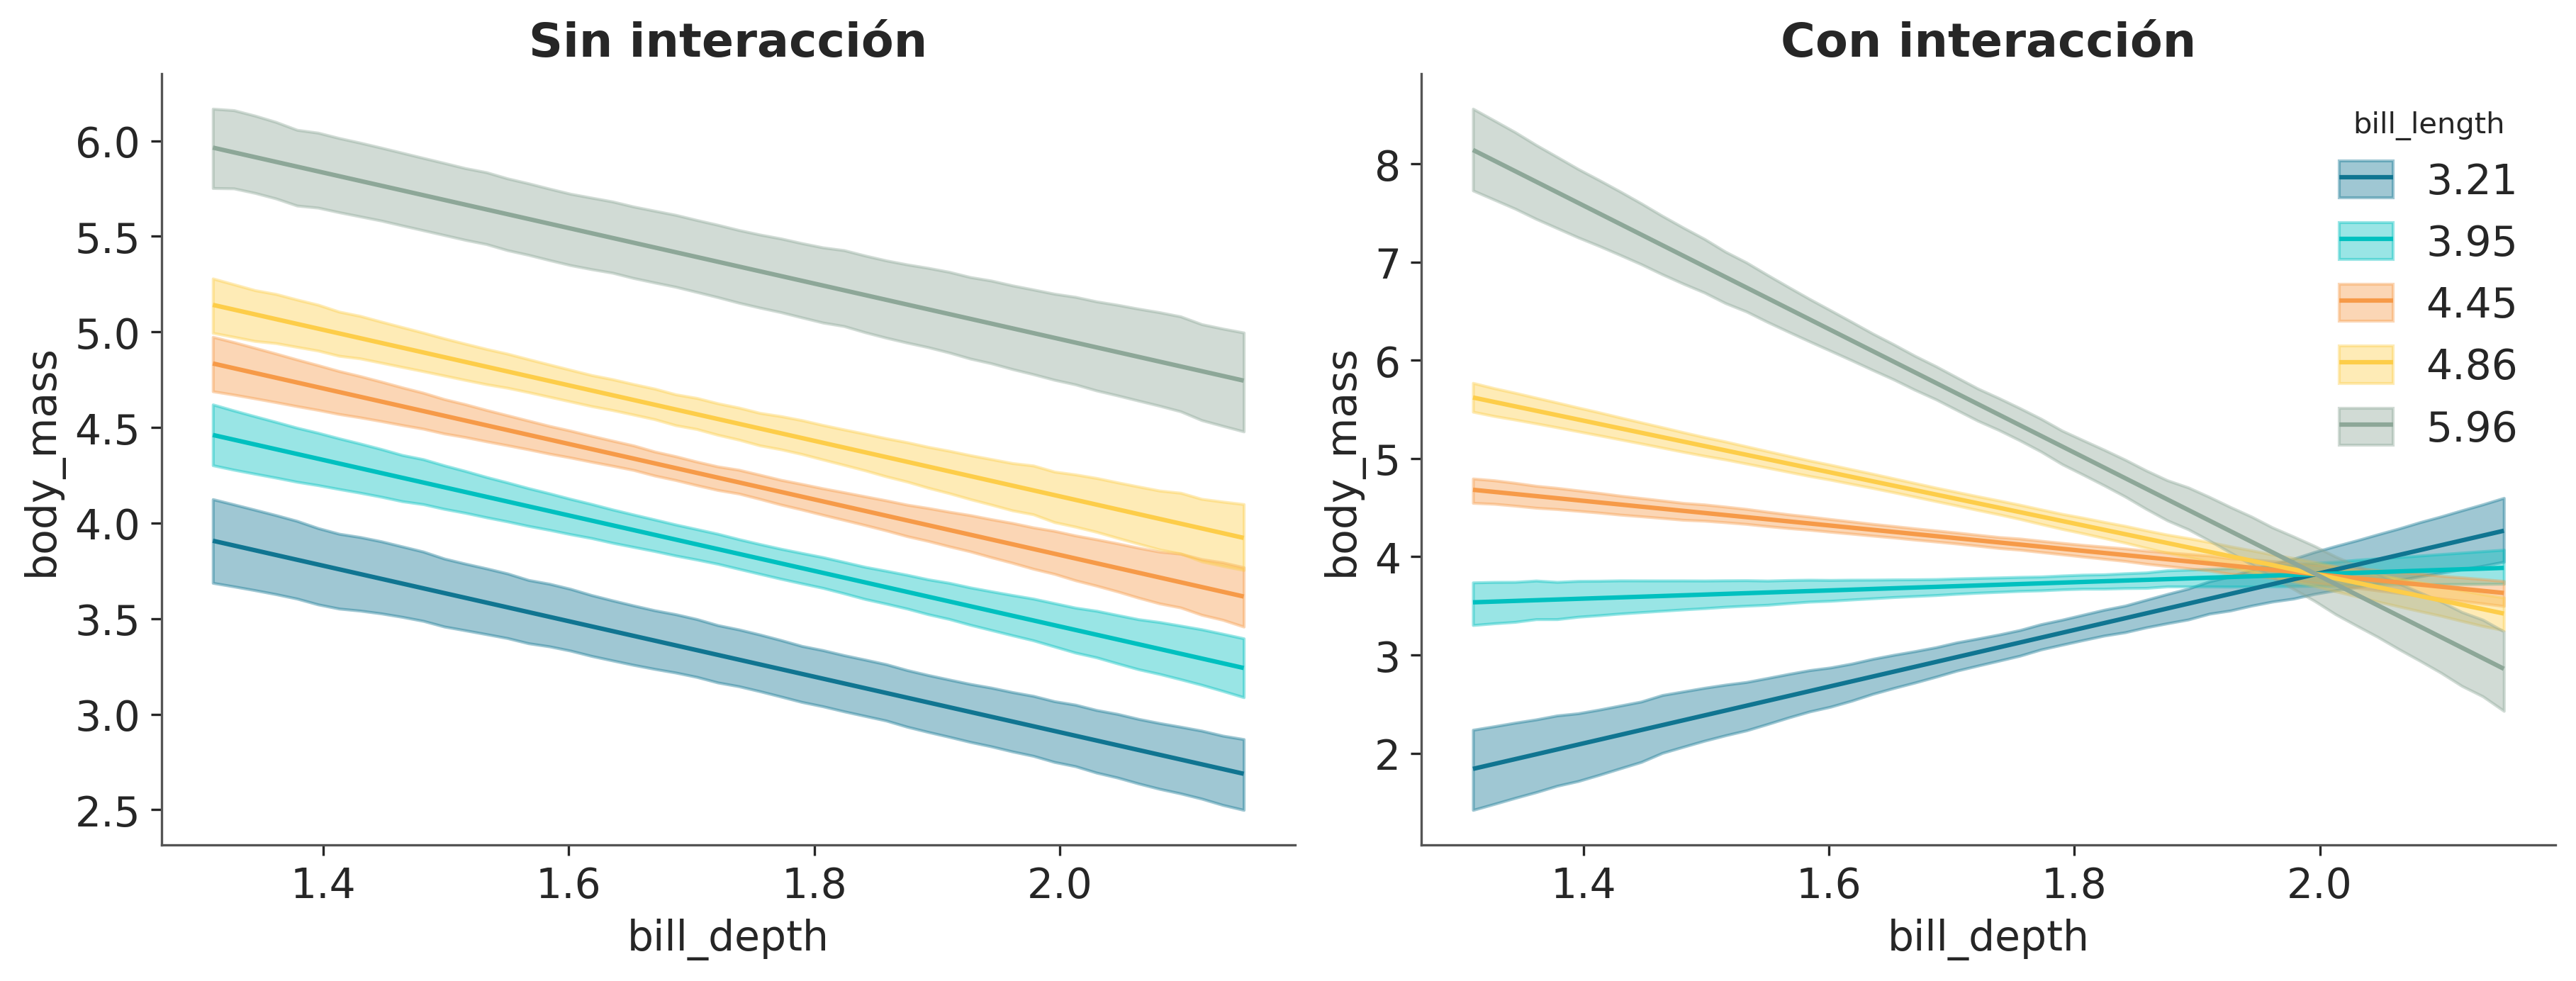

In [35]:
#| code-fold: true
#| label: fig-interaction_vs_noninteraction
#| fig-cap: Comparación de un modelo sin interacción (las lineas se mantienen paralelas) y con interacción (las lineas se cruzan).

_, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'hspace': 0.1})

bmb.interpret.plot_predictions(model_noint, idata_noint,
                                ["bill_depth",  "bill_length"],
                                ax=axes[0],
                                legend=False,
                                )
axes[0].set_title("Sin interacción")


bmb.interpret.plot_predictions(model_int, idata_int,
                               ["bill_depth",  "bill_length"],
                                ax=axes[1],
                                )
axes[1].set_title("Con interacción");


Acabamos de ver visualmente que interpretar modelos lineales con interacciones no es tan fácil como interpretar modelos lineales sin ellas. Veamos esto matemáticamente:

Supongamos que tenemos un modelo con 2 variables $X_0$ y $X_1$ y una interacción entre ellas:

$$
     \mu = \alpha + \beta_0 X_0 + \beta_1 X_1 + \beta_3 X_0X_1
$$

podemos reescribir este modelo como:

$$
\mu = \alpha + \underbrace{{(\beta_0 + \beta_2} X_1)}_{\text{pendiente de } X_0} X_0 + \beta_1 X_1
$$

o así:

$$
\mu = \alpha + \beta_0 X_0 + \underbrace{(\beta_1 + \beta_2 x_0)}_{\text{pendiente de } X_1} X_1
$$

Esto nos muestra el siguiente gráfico de Fores para la distribución a posteriori de:

* ¡El término de interacción puede entenderse como un modelo lineal dentro de un modelo lineal!
* La interacción es simétrica; podemos pensar en ello como la pendiente de $x_0$ en función de $x_1$ y al mismo tiempo como la pendiente de $x_1$ en función de $x_0$. Esto también se puede ver en la figura interactiva.
* Sabemos desde antes que el coeficiente $\beta_0$ se puede interpretar como la cantidad de cambio de $\mu$ por unidad de cambio de $x_0$ (por eso lo llamamos pendiente). Si agregamos un término de interacción, entonces esto solo es cierto en $x_1 = 0$. Intente utilizar la figura interactiva para verlo usted mismo. Matemáticamente, esto es cierto porque cuando $x_1 = 0$ entonces $\beta_2x_1 = 0$, y por lo tanto la pendiente de $x_0$ se reduce a $\beta_0 x_0$. Por simetría, el mismo razonamiento se puede aplicar a $\beta_1$.
\end{detallar}

## Interpretando modelos con Bambi

Ya hemos usado `bmb.interpret_plot_predictions` en este capítulo. Pero esa no es la única herramienta que nos ofrece Bambi para ayudarnos a comprender los modelos. Otra opción es `bmb.interpret_plot_comparisons`. Esta herramienta nos ayuda a responder la pregunta: ¿Cuál es la diferencia predictiva esperada cuando comparamos dos valores de una variable determinada mientras mantenemos el resto en valores constantes?


Como ejemplo usemos `model_int`, que ya ajustamos en la sección anterior.

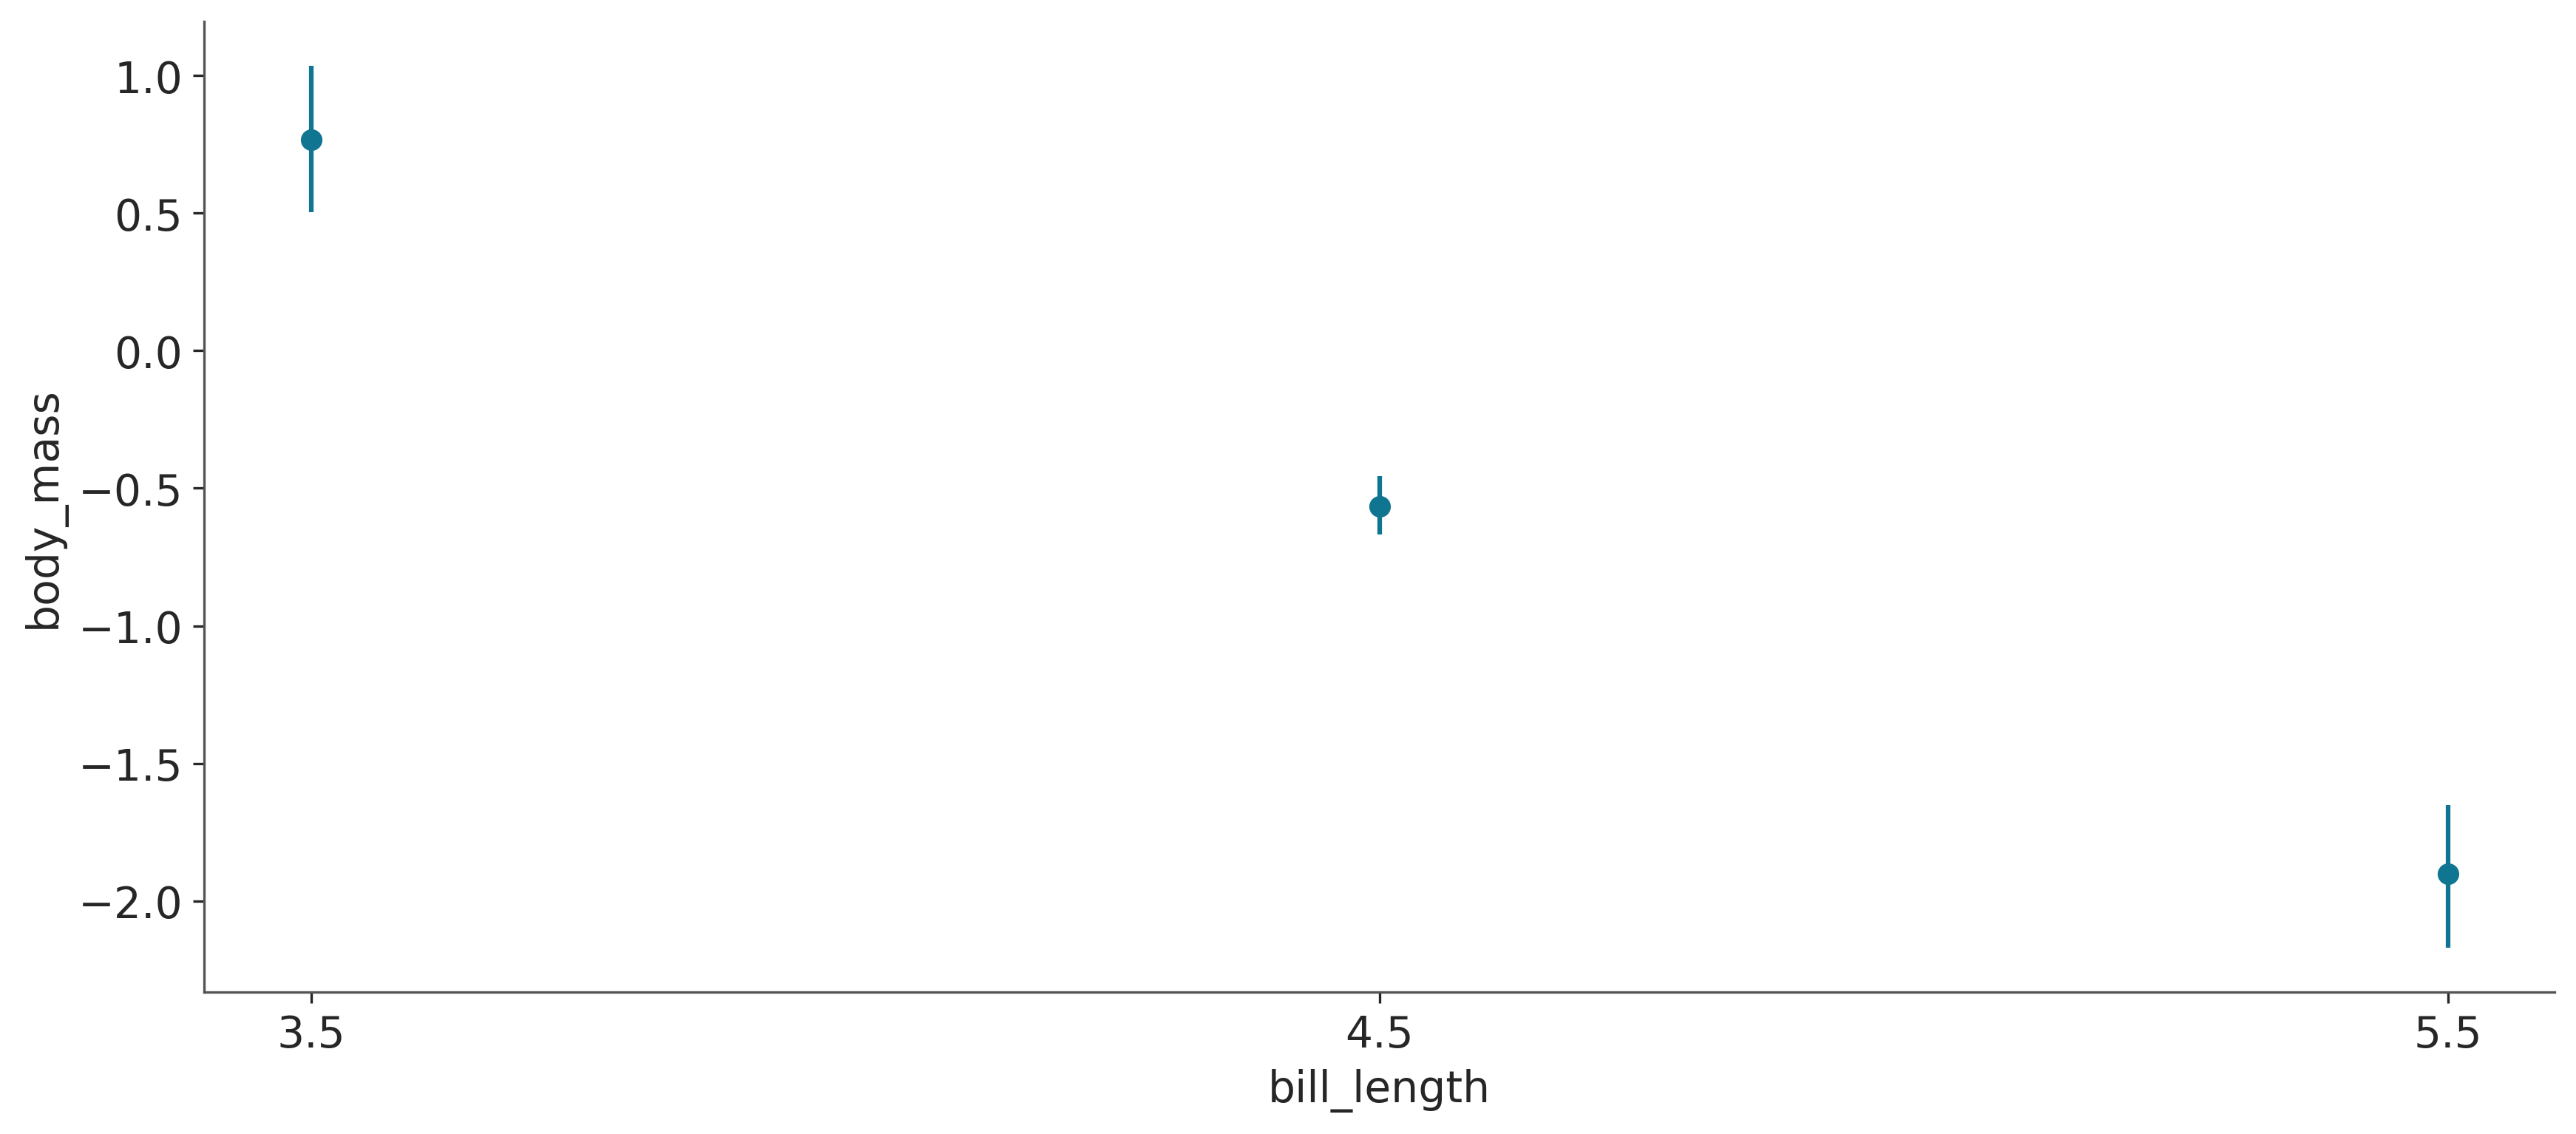

In [36]:
#| label: fig-interaction_comparisons
#| fig-cap: Contraste de para `bill_length` de 1,8 a 1,4 cm para 3 valores fijos de `bill_length`, 3.5, 4.5 y 5.5.

bmb.interpret.plot_comparisons(model_int, idata_int,
                               contrast={"bill_depth":[1.4, 1.8]},
                               conditional={"bill_length":[3.5, 4.5, 5.5]});

@fig-interaction_comparisons muestra que al comparar un pingüino hipotético con profundidad de pico (`bill_depth`) de 1,8 con uno con profundida de pico de 1,4, la diferencia esperada es:

* aproximadamente 0,8 kg para un pico de 3,5 de longitud
* -0,7 kg para un pico de 4,5 de largo
* aproximadamente -2 kg para un pico de 5,5 de largo


Para obtener esta misma información, pero en forma de tabla podemos usar la función `bmb.interpret.comparisons` y obtendremos un DataFrame de Pandas.

In [37]:
#| code-fold: true
bmb.interpret.comparisons(model_int, idata_int,
                          contrast={"bill_depth":[1.4, 1.8]},
                          conditional={"bill_length":[3.5, 4.5, 5.5]})

,term,estimate_type,value,bill_length,estimate,lower_3.0%,upper_97.0%
0,bill_depth,diff,"(1.4, 1.8)",3.5,0.767716,0.503219,1.035987
1,bill_depth,diff,"(1.4, 1.8)",4.5,-0.567180,-0.667925,-0.455735
2,bill_depth,diff,"(1.4, 1.8)",5.5,-1.902077,-2.171324,-1.652258


Otra función muy útil es Otra función útil es `bmb.interpret_plot_slopes`. Esta función es similar a `bmb.interpret_plot_comparison`, la "tasa de cambio instantánea" o pendiente en un valor dado.

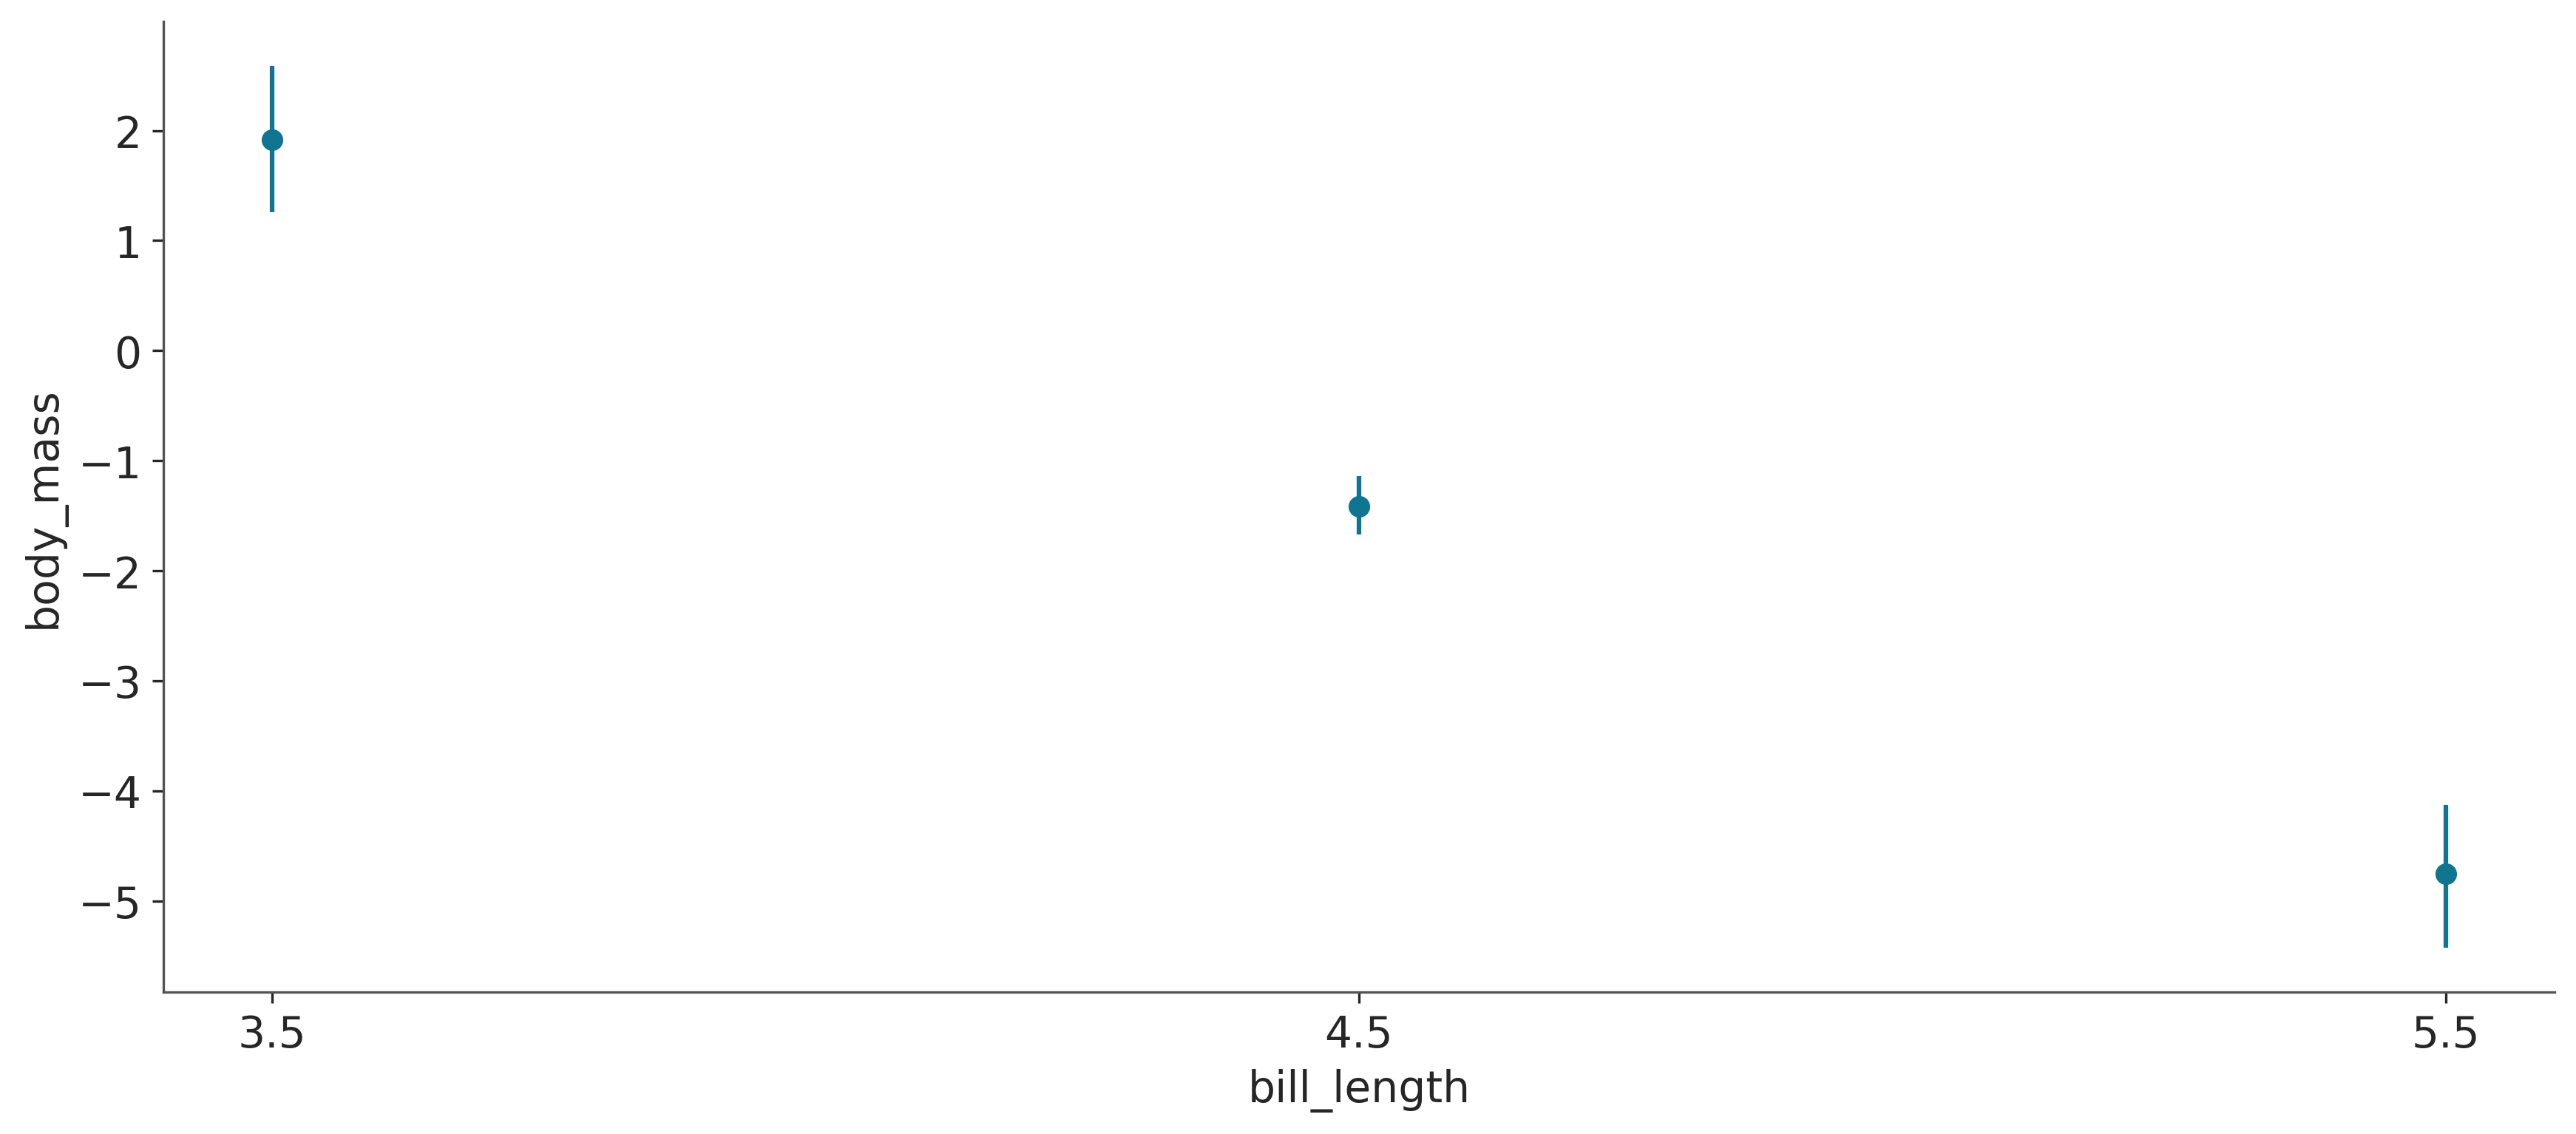

In [38]:
#| label: fig-interaction_slopes
#| fig-cap: Comparación de las pendientes de bill_depth evaluada en 1.8 para tres valores de `bill_length`, 3.5, 4.5 y 5.5.

bmb.interpret.plot_slopes(model_int, idata_int,
                          wrt={"bill_depth":1.8},
                          conditional={"bill_length":[3.5, 4.5, 5.5]});

La @fig-interaction_slopes muestra que las pendientes para `bill_depth` en 1.8 son:

* $\approx$ 2 kg/cm para un largo de pico de 3.5
* -1.4 kg/cm para un largo de pico de4.5
* $\approx$ -5 kg/cm para un largo de pico de 5.5


Si deseas esta información en forma tabular, podés usar: la función `bmb.interpret.slopes` y obtendrás un DataFrame en lugar de un gráfico.


In [39]:
#| code-fold: true

bmb.interpret.slopes(model_int, idata_int,
                     wrt={"bill_depth":1.8},
                     conditional={"bill_length":[3.5, 4.5, 5.5]})

,term,estimate_type,value,bill_length,estimate,lower_3.0%,upper_97.0%
0,bill_depth,dydx,"(1.8, 1.8001)",3.5,1.919289,1.258048,2.589967
1,bill_depth,dydx,"(1.8, 1.8001)",4.5,-1.417951,-1.669811,-1.139338
2,bill_depth,dydx,"(1.8, 1.8001)",5.5,-4.755192,-5.428310,-4.130645



En esta sección, apenas hemos arañado la superficie de lo que podemos hacer con las herramientas del módulo `bmb.interpret`. Este módulo es una característica muy útil de Bambi, especialmente para modelos con interacciones y/o modelos con funciones de enlace distintas a la función de identidad. Les recomiendo que lea la [documentación](https://bambinos.github.io/bambi/notebooks/#tools-to-interpret-model-outputs) de Bambi para obtener más ejemplos y detalles que no se tratan aquí.